# 1 IMPORTS

In [159]:
%matplotlib inline

import numpy             as np
import pandas            as pd
import re
import statistics
import seaborn           as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display     import Image
import warnings

from tabulate                import tabulate
from scipy.stats             import chi2_contingency
from collections             import Counter
from sklearn                 import metrics
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn                 import ensemble as en

from collections          import Counter
from imblearn.combine     import SMOTETomek
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors    import KNeighborsClassifier
from imblearn.ensemble    import BalancedRandomForestClassifier
import xgboost            as xgb
from catboost             import CatBoostClassifier
import lightgbm           as lightgbm
from lightgbm             import LGBMClassifier
from sklearn.naive_bayes  import GaussianNB


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics         import roc_auc_score, f1_score, accuracy_score, cohen_kappa_score
from sklearn.metrics         import precision_score, recall_score
from sklearn.metrics         import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics         import classification_report, roc_curve, brier_score_loss

## 1.1 Definição de funções

In [2]:
def data_anuncio(x):
    data_=x['código_do_anunciante'].value_counts()
    data_1 = pd.DataFrame(data_).reset_index()
    data_1.columns=['código_do_anunciante1', 'QTDE_Anuncios']
    return data_1


def data_marca(x):
    data__=x['cod_marca_veiculo'].value_counts()
    data__1 = pd.DataFrame(data__).reset_index()
    data__1.columns=['cod_marca_veiculo1', 'QTDE_Marca']
    
    return data__1

def data_versao(x):
    data___=x['cod_versao_veiculo'].value_counts()
    data___1 = pd.DataFrame(data___).reset_index()
    data___1.columns=['cod_versao_veiculo1', 'QTDE_Marca']
    
    return data___1


# Padrão para plotagens
def data_load(ax1, title, xlabel, ylabel):
    ax1.set_title(title,  fontsize=15)
    ax1.set_xlabel(xlabel, fontsize=15)
    ax1.set_ylabel(ylabel, fontsize=15)
    return None
# Tornar legível nome das cidades selecionadas
def nome_correct(x):
    for idx, _ in x.iterrows():
        if (data['Cidade'].at[idx]=='So Bernardo do Campo'):
            data['Cidade'].at[idx]='Sao Bernardo do campo'
        if (data['Cidade'].at[idx]=='Santo Andr'):
            data['Cidade'].at[idx]='Santo Andre'
        if (data['Cidade'].at[idx]=='So Jos do Rio Preto'):
            data['Cidade'].at[idx]='Sao Jose do Rio Preto'
        if (data['Cidade'].at[idx]=='So Jos dos Campos'):
            data['Cidade'].at[idx]='Sao Jose dos Campos'
        if (data['Cidade'].at[idx]=='Goinia'):
            data['Cidade'].at[idx]='Goiania'
        if (data['Cidade'].at[idx]=='Jundia'):
            data['Cidade'].at[idx]='Jundiai'
        if (data['Cidade'].at[idx]=='So Jos'):
            data['Cidade'].at[idx]='Sao Jose'
        if (data['Cidade'].at[idx]=='So Caetado do Sul'):
            data['Cidade'].at[idx]='Sao Caetano do Sul'
        else:
            data['Cidade']


def atributo_frequencia(atributo):
    
    atributo_dict = atributo.value_counts().to_dict()
    
    df_atributo_dict = pd.DataFrame(atributo_dict.items(), columns=['Value','Count'])

    df_atributo_dict['frequency'] = df_atributo_dict['Count'] / df_atributo_dict['Count'].sum()
    
    atributo_frequencia = df_atributo_dict.set_index('Value').to_dict()['frequency']
    
    return atributo_frequencia


def frequencias_codificadas(data_frame):
    
    freq_codificada = pd.DataFrame()
    
    for column in data_frame.columns:
        freq_codificada[column] = data_frame[column].map(atributo_frequencia(data_frame[column]))
        
    return freq_codificada


class Utilidades(object):
    def cramerv(self, var_x, var_y):
        confusion_matrix_v = pd.crosstab(var_x, var_y).values

        n = confusion_matrix_v.sum()

        l, c = confusion_matrix_v.shape

        chi2 = chi2_contingency(confusion_matrix_v)[0]

        # correção 
        chi2corr = max(0, chi2 - (c-1) * (l-1) / (n-1))
        ccorr = c - (c-1) ** 2 / (n-1)
        lcorr = l - (l-1) ** 2 / (n-1)

        return np.sqrt((chi2corr/n) / min(ccorr-1, lcorr-1))

    # performance de modelos de classificação 
    def performance_modelo(self, X_train, X_test, y_train, y_test, threshold, classifiers):

        dataframe_performance = pd.DataFrame()

        for clf in classifiers:
            print("Training " + type(clf).__name__ + "...")
            
            clf.fit(X_train, y_train)

            clf_probs = clf.predict_proba(X_test)

            clf_accuracy, clf_kappa, clf_f1, clf_auc, clf_precision, clf_recall = self.calculo_metricas_modelos(clf,
                                                                                                               X_test, y_test,
                                                                                                               clf_probs, threshold)

            clf_dict = {
                'model': [type(clf).__name__, '---'],
                'precision': [clf_precision, np.nan],
                'recall': [clf_recall, np.nan],
                'f1-Score': [clf_f1, np.nan],
                'ROC AUC': [clf_auc, np.nan],
                'accuracy': [clf_accuracy, np.nan],
                'cohen kappa': [clf_kappa, np.nan]}

            dataframe_performance = pd.concat([dataframe_performance, pd.DataFrame(clf_dict)])

        dataframe_performance = dataframe_performance.reset_index()

        dataframe_performance.drop('index', axis=1, inplace=True)

        rows_to_drop = np.arange(1, len(classifiers)*2, 2)

        dataframe_performance.drop(rows_to_drop, inplace=True)

        return dataframe_performance

    def calculo_metricas_modelos(self, model, X_test, y_test, model_probs, threshold):
            """
                Calcular Acurácia, F1-Score, PR AUC
            """
            probs = pd.DataFrame(model_probs[:, 1], columns=['prob'])

            y_pred = probs['prob'].apply(lambda x: 1 if x > threshold else 0)

            f1 = f1_score(y_test, y_pred)

            accuracy = accuracy_score(y_test, y_pred)

            kappa = cohen_kappa_score(y_test, y_pred)

            auc_score = roc_auc_score(y_test, probs)

            precision = precision_score(y_test, y_pred)

            recall = recall_score(y_test, y_pred)

            return accuracy, kappa, f1, auc_score, precision, recall



In [3]:
UG = Utilidades()

## 1.2 Carregando Dados

In [55]:
data = pd.read_csv('Datasets/Case 1 - dados.csv',encoding='utf-8')
data_dicionario = pd.read_csv('Datasets/Case 1 - dicionario.csv')

Aqui temos um dicionário com as legendas de todas as variáveis do dataset que usaremos para esse projeto sobre a presença ou ausência de leads, com o objetivo de facilitar a leitura de todas as informações.

In [56]:
data_dicionario

,attribute,description
0,cod_anuncio,código do anúncio
1,cod_cliente,código do anunciante
2,cod_tipo_pessoa,"tipo de anunciante: PF=1, PJ=2"
3,prioridade,"prioridade do anúncio (1=alta, 2-média, 3-baixa)"
4,leads,tota de propostas recebidas
5,views,quantidade de visualizações no anúncio
6,cliques_telefone,quantidade de cliques no telefone anunciado
7,cod_marca_veiculo,código da marca do veículo
8,cod_modelo_veiculo,código do modelo veículo
9,cod_versao_veiculo,código da versão do veículo


# 2 Descrição dos dados

## 2.1 Observação dos dados

In [57]:
data.head(3)

,cod_anuncio,cod_cliente,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone*,cod_marca_veiculo,cod_modelo_veiculo,cod_versao_veiculo,...,arquente,bancocouro,arcondic,abs,desembtras,travaeletr,vidroseletr,rodasliga,sensorchuva,sensorestacion
0,2,7941,2,3,1,0,0,34,769,346932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,1770,1,3,1,0,4,2,704,340148,...,S,N,N,S,N,S,S,N,N,N
2,8,709,1,3,4,0,11,30,1071,310713,...,S,N,S,S,S,S,S,S,N,N


## 2.2 Formatação e tipos dos dados

In [58]:
data.columns = ['cod_anuncio', 'código_do_anunciante', 'cod_tipo_pessoa', 'prioridade', 'leads',
       'views', 'cliques_telefone', 'cod_marca_veiculo', 'cod_modelo_veiculo',
       'cod_versao_veiculo', 'ano_modelo', 'cep_2dig', 'uf_cidade',
       'vlr_anuncio', 'qtd_fotos', 'km_veiculo', 'vlr_mercado',
       'flg_unico_dono', 'flg_licenciado', 'flg_ipva_pago',
       'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_garantia_fabrica',
       'flg_blindado', 'flg_aceita_troca', 'flg_adaptado_pcd', 'combustivel',
       'cambio', 'portas', 'alarme', 'airbag', 'arquente', 'bancocouro',
       'arcondicionado', 'abs', 'desembaraçador_traseiro', 'travaeletrica', 'vidroseletricos',
       'rodasliga', 'sensor_chuva', 'sensor_estacionamento']
data.head(3)

,cod_anuncio,código_do_anunciante,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone,cod_marca_veiculo,cod_modelo_veiculo,cod_versao_veiculo,...,arquente,bancocouro,arcondicionado,abs,desembaraçador_traseiro,travaeletrica,vidroseletricos,rodasliga,sensor_chuva,sensor_estacionamento
0,2,7941,2,3,1,0,0,34,769,346932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,1770,1,3,1,0,4,2,704,340148,...,S,N,N,S,N,S,S,N,N,N
2,8,709,1,3,4,0,11,30,1071,310713,...,S,N,S,S,S,S,S,S,N,N


Nesse dataset observamos algumas variáveis sem tanta clareza na leitura como **uf_cidade** e **vlr_mercado**.Vamos alterar um pouco essas colunas separando estado e cidade colocando-as em outras 2 colunas. Valor de mercado também criaremos outra coluna com apenas 2 casas decimais para deixar legível, sem apagar a primeira para não perder informação.

In [59]:
data[["Estado", "Cidade"]] = data["uf_cidade"].str.split('_', expand = True)

data.drop(columns=['uf_cidade'], inplace = True)

# tornando legível o nome da cidade com mais frequência
for idx, _ in data.iterrows():
    if (data['Cidade'].at[idx]=='SÃ£o Paulo'):
        data['Cidade'].at[idx]='Sao Paulo'
    else:
        data['Cidade']

# Retirando valores especiais da variável Cidade
data['Cidade'] = data['Cidade'].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "",x))

# Criando e reescalando para duas casas decimais valor de mercado
data['vlr_mercado_2'] = round(data['vlr_mercado'],2)

data[['Estado','Cidade','vlr_mercado','vlr_mercado_2']].tail(3)

,Estado,Cidade,vlr_mercado,vlr_mercado_2
48662,SP,Jundia,81696.56707,81696.57
48663,SP,Jundia,45804.01330,45804.01
48664,SP,Jundia,33437.95609,33437.96


## 2.3 Checando e Tratando os dados vazio

Nos dados vazios iremos excluir de **vlr_mercado**, pois não tem como substituir por nenhuma valor.Mesmo assim, não perderemos tanta informação ja que temos muitos dados. Para as outras vazias que sobraram, podemos substituir pela moda.

In [60]:
data.isna().sum()

cod_anuncio                             0
código_do_anunciante                    0
cod_tipo_pessoa                         0
prioridade                              0
leads                                   0
views                                   0
cliques_telefone                        0
cod_marca_veiculo                       0
cod_modelo_veiculo                      0
cod_versao_veiculo                      0
ano_modelo                              0
cep_2dig                                0
vlr_anuncio                             0
qtd_fotos                               0
km_veiculo                              0
vlr_mercado                          6217
flg_unico_dono                          0
flg_licenciado                          0
flg_ipva_pago                         312
flg_todas_revisoes_concessionaria     312
flg_todas_revisoes_agenda_veiculo       0
flg_garantia_fabrica                  312
flg_blindado                            0
flg_aceita_troca                  

In [61]:
data.dropna(subset=['vlr_mercado'],inplace=True)

# Calculando a moda de algumas variáveis
flg_ipva_pago_moda = statistics.mode(data['flg_ipva_pago'])
flg_todas_revisoes_concessionaria_moda = statistics.mode(data['flg_todas_revisoes_concessionaria'])
flg_garantia_fabrica_moda = statistics.mode(data['flg_garantia_fabrica'])
flg_adaptado_pcd_moda = statistics.mode(data['flg_adaptado_pcd'])
airbag_moda = statistics.mode(data['airbag'])

# Substituindo valores vazios pela moda
data['flg_ipva_pago'] = data['flg_ipva_pago'].fillna(flg_ipva_pago_moda)
data['flg_todas_revisoes_concessionaria'] = data['flg_todas_revisoes_concessionaria'].fillna(flg_todas_revisoes_concessionaria_moda)
data['flg_garantia_fabrica'] = data['flg_garantia_fabrica'].fillna(flg_garantia_fabrica_moda)
data['flg_adaptado_pcd'] = data['flg_adaptado_pcd'].fillna(flg_adaptado_pcd_moda)
data['airbag'] = data['airbag'].fillna(airbag_moda)

In [62]:
# Checando dados vazios
data.isna().sum()

cod_anuncio                          0
código_do_anunciante                 0
cod_tipo_pessoa                      0
prioridade                           0
leads                                0
views                                0
cliques_telefone                     0
cod_marca_veiculo                    0
cod_modelo_veiculo                   0
cod_versao_veiculo                   0
ano_modelo                           0
cep_2dig                             0
vlr_anuncio                          0
qtd_fotos                            0
km_veiculo                           0
vlr_mercado                          0
flg_unico_dono                       0
flg_licenciado                       0
flg_ipva_pago                        0
flg_todas_revisoes_concessionaria    0
flg_todas_revisoes_agenda_veiculo    0
flg_garantia_fabrica                 0
flg_blindado                         0
flg_aceita_troca                     0
flg_adaptado_pcd                     0
combustivel              

## 2.4 Alterando os Tipos de Dados

In [63]:
data['km_veiculo'] = data['km_veiculo'].astype( float )

data['flg_ipva_pago'] = data['flg_ipva_pago'].astype( int )

data['flg_todas_revisoes_concessionaria'] = data['flg_todas_revisoes_concessionaria'].astype( int )

data['flg_garantia_fabrica'] = data['flg_garantia_fabrica'].astype( int )

data['flg_adaptado_pcd'] = data['flg_adaptado_pcd'].astype( int )

data['portas'] = data['portas'].astype( int )

# 3 Estatística descritiva

**1**. Vamos criar duas ferramentas para facilitar as leituras de curtose e simetria.

**2**. Observamos valores altos nas curtoses de **vlr_anuncio** e **km_veiculo** devido à valores discrepantes em ambos.

**3**. Observamos também valores altos nas curtoses de outras variáveis devido à valores elevados no ponto máximo, mas que não podemos fazer nada, pois são valores possíveis.


## 3.1 Atributos Numéricos

In [64]:
# Selecionando dados int e float das 15 primeiras variáveis
NA1 = data.select_dtypes(['int64', 'float64','int32'])
NA1 = NA1.iloc[:,0:15]

In [65]:
# Criando recurso de simetria 
Simetria = pd.DataFrame(NA1.apply(lambda x: x.skew())).round(2).T
Simetria.rename(index={0: 'Simetria'}, inplace=True)

# Criando recurso de curtose
Curtose = pd.DataFrame(NA1.apply(lambda x: x.kurtosis())).round(2).T
Curtose.rename(index={0: 'Curtose'}, inplace=True)

describe = NA1.describe().round(2)
m1 = pd.concat([describe, Simetria, Curtose], axis=0)
m1

,cod_anuncio,código_do_anunciante,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone,cod_marca_veiculo,cod_modelo_veiculo,cod_versao_veiculo,ano_modelo,cep_2dig,vlr_anuncio,qtd_fotos,km_veiculo
count,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,4.244800e+04,42448.00,4.244800e+04
mean,101121.54,8430.90,1.87,2.61,4.18,465.87,7.02,18.67,2071.22,343140.92,2013.50,38.38,8.497923e+04,6.68,2.830103e+05
std,55584.16,7574.14,0.34,0.77,11.54,1154.88,10.96,36.46,1110.63,8527.95,3.47,33.57,1.550029e+06,2.14,1.813194e+07
min,31.00,1.00,1.00,1.00,0.00,0.00,0.00,2.00,650.00,1429.00,1951.00,1.00,4.900000e+03,0.00,0.000000e+00
25%,53631.75,3581.00,2.00,3.00,1.00,84.00,2.00,4.00,788.00,342625.00,2012.00,9.00,3.090000e+04,6.00,3.400000e+04
50%,101719.50,6599.00,2.00,3.00,1.00,208.00,4.00,5.00,2487.00,344130.00,2014.00,22.00,3.999000e+04,8.00,5.944800e+04
75%,149455.00,10181.00,2.00,3.00,4.00,476.00,8.00,26.00,3202.00,345485.00,2016.00,78.00,6.090000e+04,8.00,8.954025e+04
max,195939.00,38733.00,2.00,3.00,364.00,93608.00,457.00,304.00,3676.00,347728.00,2019.00,99.00,1.220000e+08,20.00,2.147484e+09
Simetria,-0.04,2.06,-2.19,-1.52,10.20,31.86,8.66,5.04,-0.05,-27.95,-2.12,0.50,5.549000e+01,-1.76,9.846000e+01
Curtose,-1.18,4.31,2.80,0.45,185.08,2050.29,167.97,26.95,-1.78,1016.15,15.63,-1.45,3.395390e+03,2.72,1.047796e+04


In [66]:
# Criando classe de curtose
Classe_curtose = pd.DataFrame(m1.loc["Curtose"].apply(lambda x:
                  'leptocúrtica_pos' if (x > 0)
                   else ' mesocúrtica' if (x == 0)
                   else 'platicúrtica_neg')).T
Classe_curtose.rename(index={'Curtose': 'Classe curtose'}, inplace=True)

#Criando classe de simetria
Classe_simetria = pd.DataFrame(m1.loc["Simetria"].apply(lambda x:
                  'quase simétrica' if (((x > 0) & (x < 0.5)) | ((x < 0) & (x > -0.5))) 
                   else 'médio enviesado' if (((x > 0.5) & (x < 1.0)) | ((x < -0.5) & (x > -1.0))) 
                   else 'muito enviesado')).T
Classe_simetria.rename(index={'Simetria': 'Classe_simetria'}, inplace=True)

m1 = pd.concat([m1, Classe_curtose, Classe_simetria], axis=0)
m1

,cod_anuncio,código_do_anunciante,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone,cod_marca_veiculo,cod_modelo_veiculo,cod_versao_veiculo,ano_modelo,cep_2dig,vlr_anuncio,qtd_fotos,km_veiculo
count,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0
mean,101121.54,8430.9,1.87,2.61,4.18,465.87,7.02,18.67,2071.22,343140.92,2013.5,38.38,84979.23,6.68,283010.31
std,55584.16,7574.14,0.34,0.77,11.54,1154.88,10.96,36.46,1110.63,8527.95,3.47,33.57,1550029.18,2.14,18131940.05
min,31.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,650.0,1429.0,1951.0,1.0,4900.0,0.0,0.0
25%,53631.75,3581.0,2.0,3.0,1.0,84.0,2.0,4.0,788.0,342625.0,2012.0,9.0,30900.0,6.0,34000.0
50%,101719.5,6599.0,2.0,3.0,1.0,208.0,4.0,5.0,2487.0,344130.0,2014.0,22.0,39990.0,8.0,59448.0
75%,149455.0,10181.0,2.0,3.0,4.0,476.0,8.0,26.0,3202.0,345485.0,2016.0,78.0,60900.0,8.0,89540.25
max,195939.0,38733.0,2.0,3.0,364.0,93608.0,457.0,304.0,3676.0,347728.0,2019.0,99.0,122000000.0,20.0,2147483647.0
Simetria,-0.04,2.06,-2.19,-1.52,10.2,31.86,8.66,5.04,-0.05,-27.95,-2.12,0.5,55.49,-1.76,98.46
Curtose,-1.18,4.31,2.8,0.45,185.08,2050.29,167.97,26.95,-1.78,1016.15,15.63,-1.45,3395.39,2.72,10477.96


In [67]:
# Selecionando dados int e float das variáveis restantes
NA2 = data.select_dtypes(['int64', 'float64','int32'])
NA2 = NA2.iloc[:,15:27]

In [68]:
# Criando recurso de simetria 
Simetria = pd.DataFrame(NA2.apply(lambda x: x.skew())).round(2).T
Simetria.rename(index={0: 'Simetria'}, inplace=True)

# Criando recurso de curtose
Curtose = pd.DataFrame(NA2.apply(lambda x: x.kurtosis())).round(2).T
Curtose.rename(index={0: 'Curtose'}, inplace=True)

describe = NA2.describe().round(2)
m2 = pd.concat([describe, Simetria, Curtose], axis=0)
m2

,vlr_mercado,flg_unico_dono,flg_licenciado,flg_ipva_pago,flg_todas_revisoes_concessionaria,flg_todas_revisoes_agenda_veiculo,flg_garantia_fabrica,flg_blindado,flg_aceita_troca,flg_adaptado_pcd,portas,vlr_mercado_2
count,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00
mean,52757.15,0.22,0.31,0.40,0.15,0.07,0.07,0.02,0.08,0.00,3.78,52757.15
std,41609.08,0.41,0.46,0.49,0.36,0.25,0.26,0.13,0.27,0.02,0.74,41609.08
min,6292.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6292.84
25%,31371.48,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,31371.48
50%,40668.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,40668.75
75%,61538.68,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,61538.68
max,1111215.64,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00,1111215.64
Simetria,4.89,1.38,0.84,0.39,1.94,3.52,3.33,7.25,3.17,51.48,-3.58,4.89
Curtose,48.49,-0.09,-1.29,-1.85,1.77,10.37,9.07,50.58,8.03,2648.31,12.90,48.49


In [69]:
# Criando classe de curtose
Classe_curtose = pd.DataFrame(m2.loc["Curtose"].apply(lambda x:
                  'leptocúrtica_pos' if (x > 0)
                   else ' mesocúrtica' if (x == 0)
                   else 'platicúrtica_neg')).T
Classe_curtose.rename(index={'Curtose': 'Classe curtose'}, inplace=True)

#Criando classe de simetria
Classe_simetria = pd.DataFrame(m2.loc["Simetria"].apply(lambda x:
                  'quase simétrica' if (((x > 0) & (x < 0.5)) | ((x < 0) & (x > -0.5))) 
                   else 'médio enviesado' if (((x > 0.5) & (x < 1.0)) | ((x < -0.5) & (x > -1.0))) 
                   else 'muito enviesado')).T
Classe_simetria.rename(index={'Simetria': 'Classe_simetria'}, inplace=True)

m2 = pd.concat([m2, Classe_curtose, Classe_simetria], axis=0)
m2

,vlr_mercado,flg_unico_dono,flg_licenciado,flg_ipva_pago,flg_todas_revisoes_concessionaria,flg_todas_revisoes_agenda_veiculo,flg_garantia_fabrica,flg_blindado,flg_aceita_troca,flg_adaptado_pcd,portas,vlr_mercado_2
count,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0
mean,52757.15,0.22,0.31,0.4,0.15,0.07,0.07,0.02,0.08,0.0,3.78,52757.15
std,41609.08,0.41,0.46,0.49,0.36,0.25,0.26,0.13,0.27,0.02,0.74,41609.08
min,6292.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6292.84
25%,31371.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,31371.48
50%,40668.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,40668.75
75%,61538.68,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,61538.68
max,1111215.64,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1111215.64
Simetria,4.89,1.38,0.84,0.39,1.94,3.52,3.33,7.25,3.17,51.48,-3.58,4.89
Curtose,48.49,-0.09,-1.29,-1.85,1.77,10.37,9.07,50.58,8.03,2648.31,12.9,48.49


## 3.2 Atributos Categóricos


In [70]:
# Selecionando dados object
CA = data.select_dtypes(['object'])

In [71]:
CA.apply( lambda x: x.unique().shape[0] )

combustivel                 10
cambio                       7
alarme                       2
airbag                       2
arquente                     2
bancocouro                   2
arcondicionado               2
abs                          2
desembaraçador_traseiro      2
travaeletrica                2
vidroseletricos              2
rodasliga                    2
sensor_chuva                 2
sensor_estacionamento        2
Estado                      27
Cidade                     850
dtype: int64

In [72]:
CA.describe(include='O')

,combustivel,cambio,alarme,airbag,arquente,bancocouro,arcondicionado,abs,desembaraçador_traseiro,travaeletrica,vidroseletricos,rodasliga,sensor_chuva,sensor_estacionamento,Estado,Cidade
count,42448,42448,42448,42448,42448,42448,42448,42448,42448,42448,42448,42448,42448,42448,42448,42448
unique,10,7,2,2,2,2,2,2,2,2,2,2,2,2,27,850
top,gasolina e alcool,manual,S,S,S,N,S,S,S,S,S,S,N,N,SP,Sao Paulo
freq,32357,23898,26600,29079,27079,28735,36556,27219,27113,36472,36182,23462,38984,30545,19873,7606


# 4 Filtrando o quadro de dados

## 4.1 Checando Outliers

Podemos observar os valores discrepantes através do gráfico do valor do anúncio e quilometragem do veículo. Então, retiramos valores acima de **1 milhão** do primeira e valores acima de **400 mil km**(apesar de existir recorde de veículo com recorde de 5milhões de km rodados) ja que existem poucos dados acima desse valor, então foi mais vantajoso deixar o gráfico o mais simétrico possível.

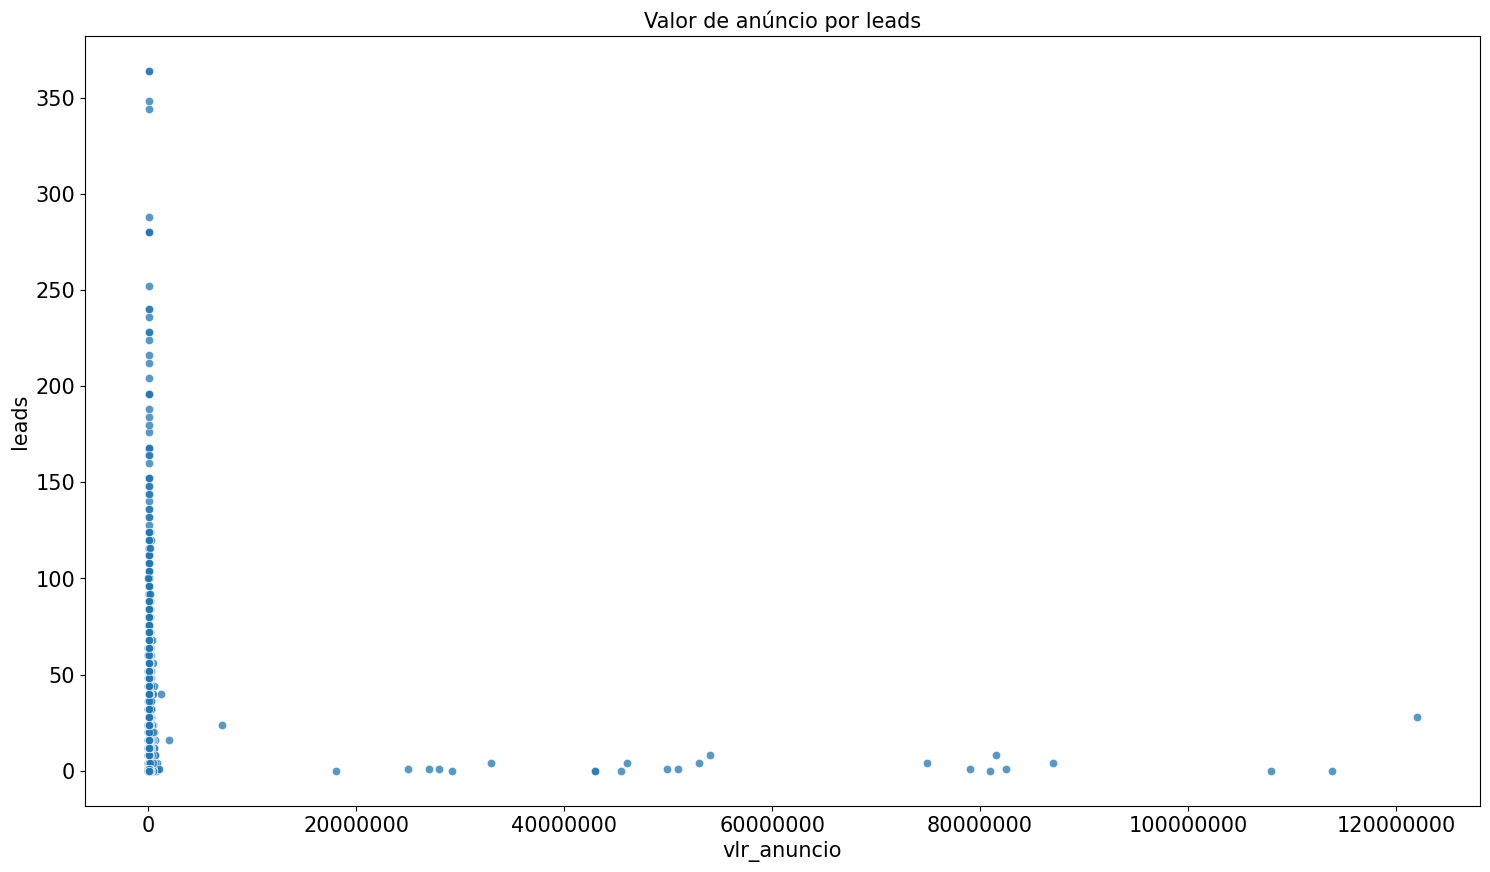

In [73]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(18,10))

ax = sns.scatterplot(x='vlr_anuncio', y='leads', data=data, palette='rainbow', alpha=0.75)
data_load(ax ,'Valor de anúncio por leads', 'vlr_anuncio','leads' )

plt.subplots_adjust(hspace=0.3)  

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.ticklabel_format(style='plain', axis='x')
  
    
plt.show()

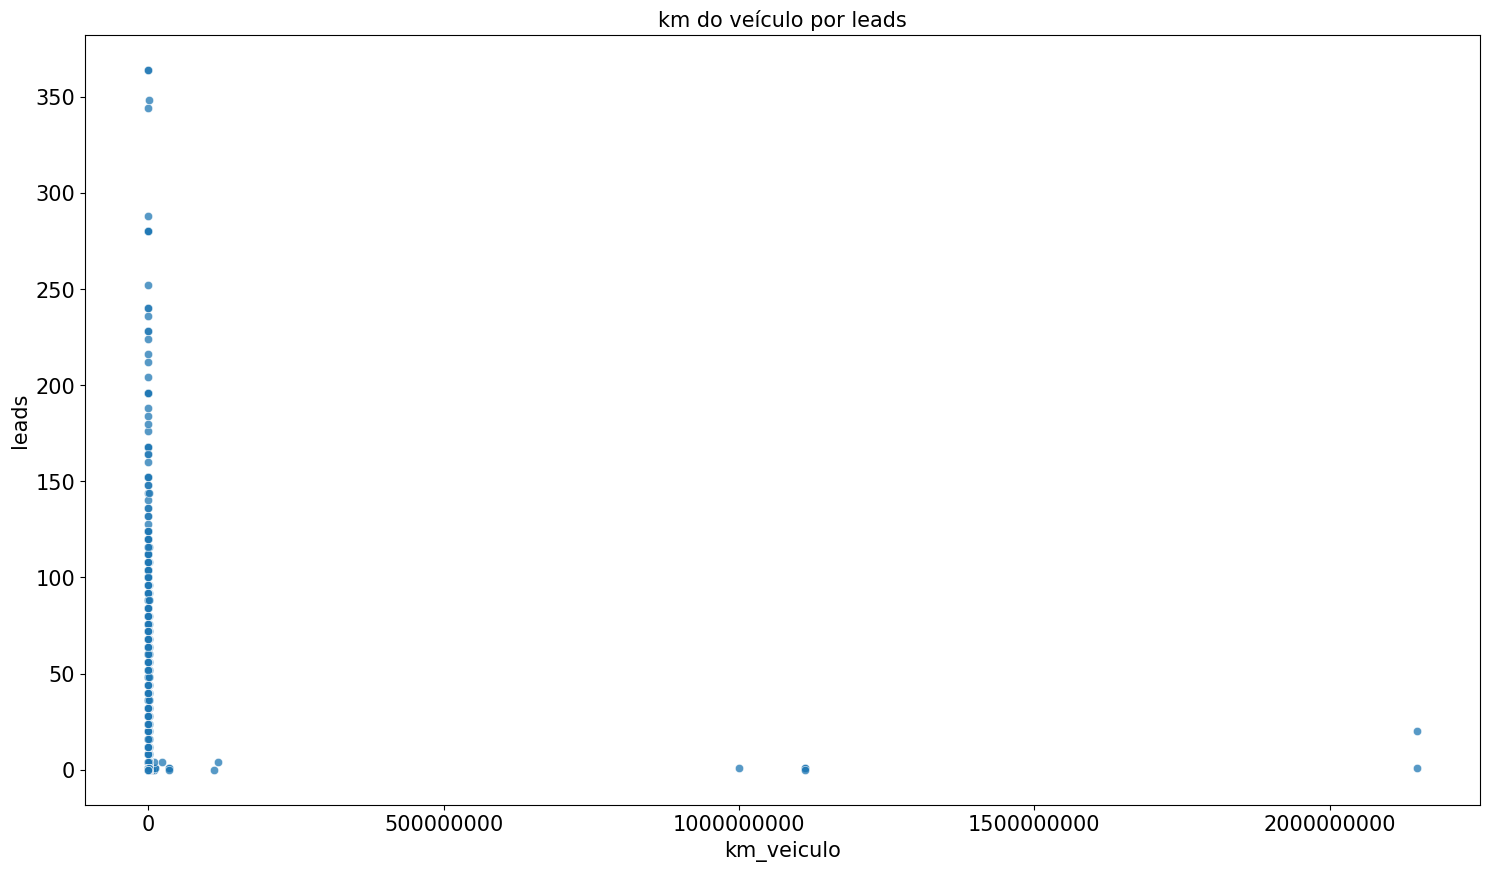

In [74]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(18,10))

ax = sns.scatterplot(x='km_veiculo', y='leads', data=data, palette='rainbow', alpha=0.75)
data_load(ax ,'km do veículo por leads', 'km_veiculo','leads' )

plt.subplots_adjust(hspace=0.3)  

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.ticklabel_format(style='plain', axis='x')
  
    
plt.show()

## 4.2 Removendo valores discrepantes

In [75]:
data_no_outliers = data.copy()
vlr_anuncio_mode = statistics.mode(data_no_outliers['vlr_anuncio'])
data_no_outliers.loc[data_no_outliers['vlr_anuncio'] > 1000000, 'vlr_anuncio'] = vlr_anuncio_mode

km_veiculo_mode = statistics.mode(data_no_outliers['km_veiculo'])
data_no_outliers.loc[data_no_outliers['km_veiculo'] > 400000, 'km_veiculo'] = km_veiculo_mode


## 4.3 Checando

Como podemos observar, se tornou mais fácil de entender os valores do gráfico de ambos e suas curtoses diminuíram bastante. Então, após retirarmos os possíveis valores discrepantes e os **NA** percebemos que está tudo certo agora.

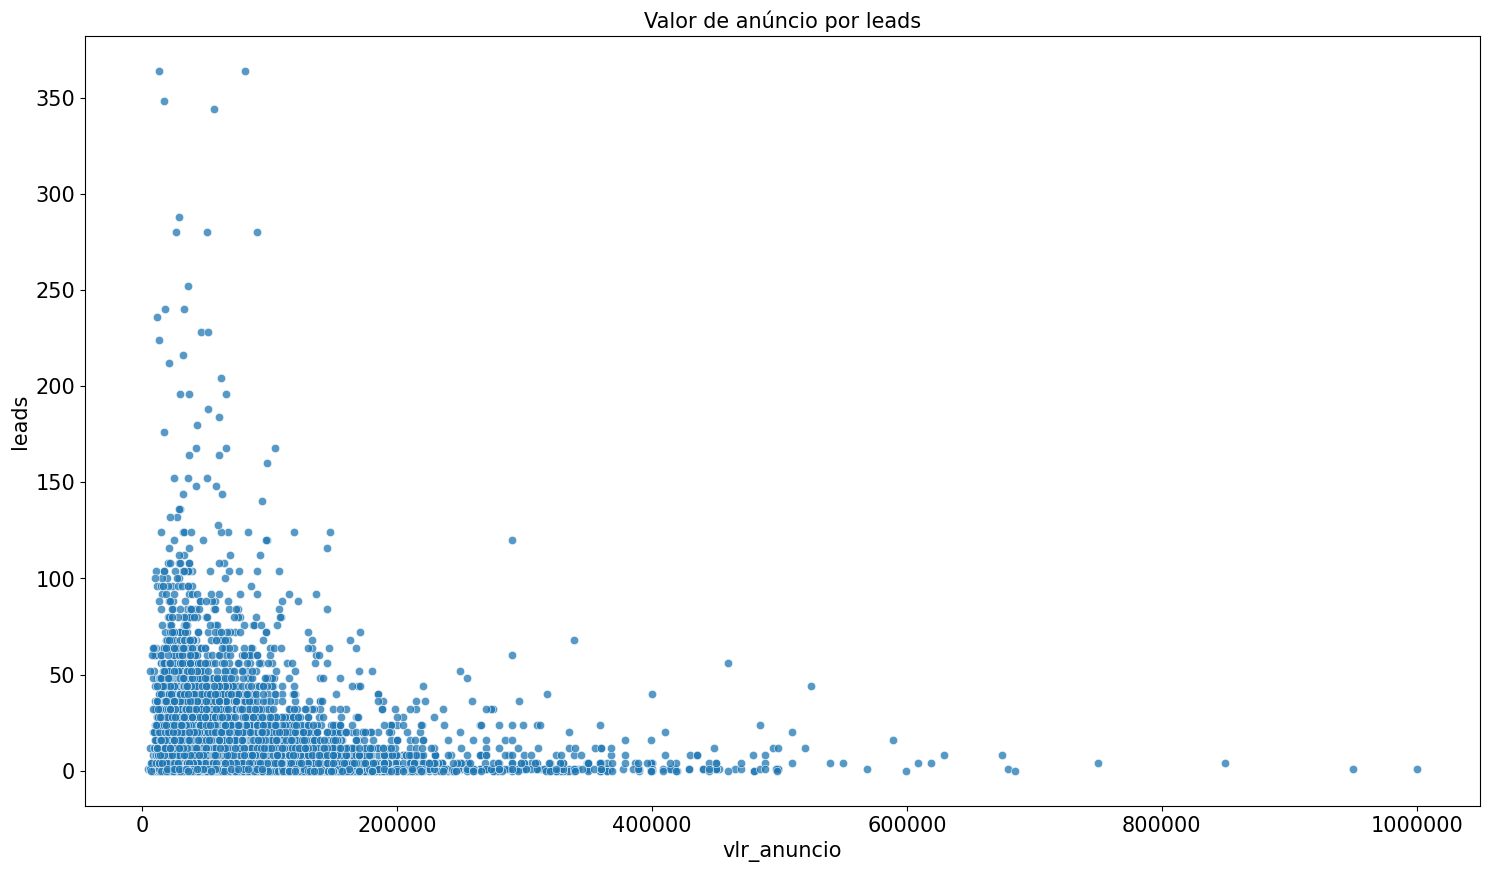

In [76]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(18,10))

ax = sns.scatterplot(x='vlr_anuncio', y='leads', data=data_no_outliers, palette='rainbow', alpha=0.75)
data_load(ax ,'Valor de anúncio por leads', 'vlr_anuncio','leads' )

plt.subplots_adjust(hspace=0.3)  

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.ticklabel_format(style='plain', axis='x')
  
    
plt.show()

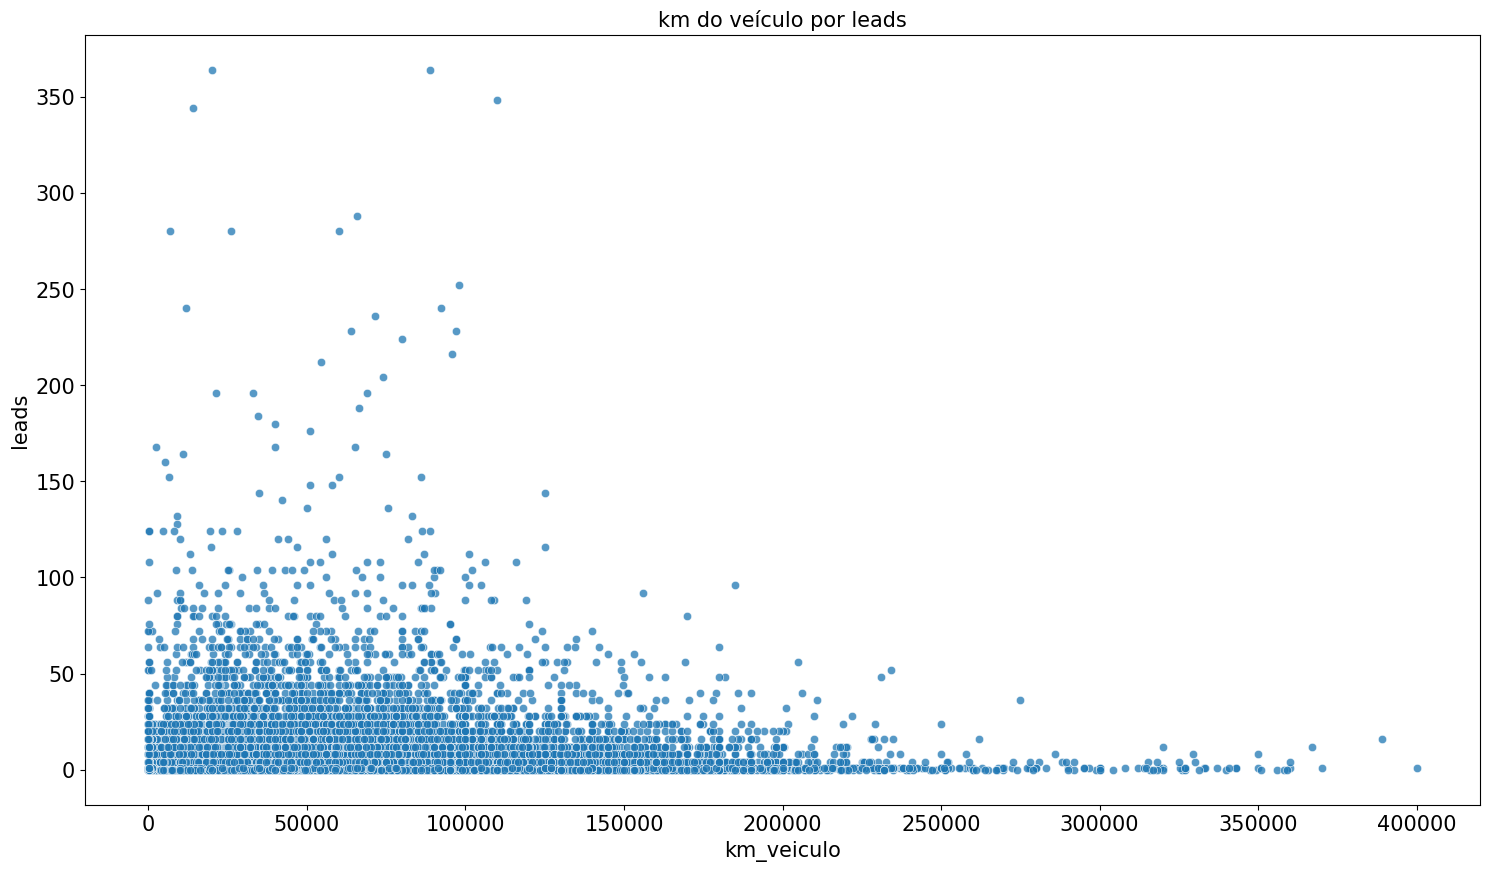

In [77]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(18,10))

ax = sns.scatterplot(x='km_veiculo', y='leads', data=data_no_outliers, palette='rainbow', alpha=0.75)
data_load(ax ,'km do veículo por leads', 'km_veiculo','leads' )

plt.subplots_adjust(hspace=0.3)  

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax.ticklabel_format(style='plain', axis='x')
  
    
plt.show()

In [78]:
# # Checando outliers e valores vazios
NA1 = data_no_outliers.select_dtypes(['int64', 'float64','int32'])
NA1 = NA1.iloc[:,0:15]

# Criando recurso de simetria 
Simetria = pd.DataFrame(NA1.apply(lambda x: x.skew())).round(2).T
Simetria.rename(index={0: 'Simetria'}, inplace=True)

# Criando recurso de curtose
Curtose = pd.DataFrame(NA1.apply(lambda x: x.kurtosis())).round(2).T
Curtose.rename(index={0: 'Curtose'}, inplace=True)

describe = NA1.describe().round(2)
m1 = pd.concat([describe, Simetria, Curtose], axis=0)
m1

,cod_anuncio,código_do_anunciante,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone,cod_marca_veiculo,cod_modelo_veiculo,cod_versao_veiculo,ano_modelo,cep_2dig,vlr_anuncio,qtd_fotos,km_veiculo
count,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00
mean,101121.54,8430.90,1.87,2.61,4.18,465.87,7.02,18.67,2071.22,343140.92,2013.50,38.38,52357.96,6.68,64071.51
std,55584.16,7574.14,0.34,0.77,11.54,1154.88,10.96,36.46,1110.63,8527.95,3.47,33.57,41610.65,2.14,43808.85
min,31.00,1.00,1.00,1.00,0.00,0.00,0.00,2.00,650.00,1429.00,1951.00,1.00,4900.00,0.00,0.00
25%,53631.75,3581.00,2.00,3.00,1.00,84.00,2.00,4.00,788.00,342625.00,2012.00,9.00,30900.00,6.00,33005.25
50%,101719.50,6599.00,2.00,3.00,1.00,208.00,4.00,5.00,2487.00,344130.00,2014.00,22.00,39990.00,8.00,58957.50
75%,149455.00,10181.00,2.00,3.00,4.00,476.00,8.00,26.00,3202.00,345485.00,2016.00,78.00,60900.00,8.00,89000.00
max,195939.00,38733.00,2.00,3.00,364.00,93608.00,457.00,304.00,3676.00,347728.00,2019.00,99.00,1000000.00,20.00,400000.00
Simetria,-0.04,2.06,-2.19,-1.52,10.20,31.86,8.66,5.04,-0.05,-27.95,-2.12,0.50,4.87,-1.76,1.04
Curtose,-1.18,4.31,2.80,0.45,185.08,2050.29,167.97,26.95,-1.78,1016.15,15.63,-1.45,46.54,2.72,2.45


In [79]:
# Criando classe de curtose
Classe_curtose = pd.DataFrame(m1.loc["Curtose"].apply(lambda x:
                  'leptocúrtica_pos' if (x > 0)
                   else ' mesocúrtica' if (x == 0)
                   else 'platicúrtica_neg')).T
Classe_curtose.rename(index={'Curtose': 'Classe curtose'}, inplace=True)

#Criando classe de simetria
Classe_simetria = pd.DataFrame(m1.loc["Simetria"].apply(lambda x:
                  'quase simétrica' if (((x > 0) & (x < 0.5)) | ((x < 0) & (x > -0.5))) 
                   else 'médio enviesado' if (((x > 0.5) & (x < 1.0)) | ((x < -0.5) & (x > -1.0))) 
                   else 'muito enviesado')).T
Classe_simetria.rename(index={'Simetria': 'Classe_simetria'}, inplace=True)

m1 = pd.concat([m1, Classe_curtose, Classe_simetria], axis=0)
m1

,cod_anuncio,código_do_anunciante,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone,cod_marca_veiculo,cod_modelo_veiculo,cod_versao_veiculo,ano_modelo,cep_2dig,vlr_anuncio,qtd_fotos,km_veiculo
count,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0
mean,101121.54,8430.9,1.87,2.61,4.18,465.87,7.02,18.67,2071.22,343140.92,2013.5,38.38,52357.96,6.68,64071.51
std,55584.16,7574.14,0.34,0.77,11.54,1154.88,10.96,36.46,1110.63,8527.95,3.47,33.57,41610.65,2.14,43808.85
min,31.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,650.0,1429.0,1951.0,1.0,4900.0,0.0,0.0
25%,53631.75,3581.0,2.0,3.0,1.0,84.0,2.0,4.0,788.0,342625.0,2012.0,9.0,30900.0,6.0,33005.25
50%,101719.5,6599.0,2.0,3.0,1.0,208.0,4.0,5.0,2487.0,344130.0,2014.0,22.0,39990.0,8.0,58957.5
75%,149455.0,10181.0,2.0,3.0,4.0,476.0,8.0,26.0,3202.0,345485.0,2016.0,78.0,60900.0,8.0,89000.0
max,195939.0,38733.0,2.0,3.0,364.0,93608.0,457.0,304.0,3676.0,347728.0,2019.0,99.0,1000000.0,20.0,400000.0
Simetria,-0.04,2.06,-2.19,-1.52,10.2,31.86,8.66,5.04,-0.05,-27.95,-2.12,0.5,4.87,-1.76,1.04
Curtose,-1.18,4.31,2.8,0.45,185.08,2050.29,167.97,26.95,-1.78,1016.15,15.63,-1.45,46.54,2.72,2.45


In [80]:
# Selecionando dados int e float das variáveis restantes
NA2 = data_no_outliers.select_dtypes(['int64', 'float64','int32'])
NA2 = NA2.iloc[:,15:27]

# Criando recurso de simetria 
Simetria = pd.DataFrame(NA2.apply(lambda x: x.skew())).round(2).T
Simetria.rename(index={0: 'Simetria'}, inplace=True)

# Criando recurso de curtose
Curtose = pd.DataFrame(NA2.apply(lambda x: x.kurtosis())).round(2).T
Curtose.rename(index={0: 'Curtose'}, inplace=True)

describe = NA2.describe().round(2)
m2 = pd.concat([describe, Simetria, Curtose], axis=0)
m2

,vlr_mercado,flg_unico_dono,flg_licenciado,flg_ipva_pago,flg_todas_revisoes_concessionaria,flg_todas_revisoes_agenda_veiculo,flg_garantia_fabrica,flg_blindado,flg_aceita_troca,flg_adaptado_pcd,portas,vlr_mercado_2
count,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00,42448.00
mean,52757.15,0.22,0.31,0.40,0.15,0.07,0.07,0.02,0.08,0.00,3.78,52757.15
std,41609.08,0.41,0.46,0.49,0.36,0.25,0.26,0.13,0.27,0.02,0.74,41609.08
min,6292.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6292.84
25%,31371.48,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,31371.48
50%,40668.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,40668.75
75%,61538.68,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,61538.68
max,1111215.64,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,4.00,1111215.64
Simetria,4.89,1.38,0.84,0.39,1.94,3.52,3.33,7.25,3.17,51.48,-3.58,4.89
Curtose,48.49,-0.09,-1.29,-1.85,1.77,10.37,9.07,50.58,8.03,2648.31,12.90,48.49


In [81]:
# Criando classe de curtose
Classe_curtose = pd.DataFrame(m2.loc["Curtose"].apply(lambda x:
                  'leptocúrtica_pos' if (x > 0)
                   else ' mesocúrtica' if (x == 0)
                   else 'platicúrtica_neg')).T
Classe_curtose.rename(index={'Curtose': 'Classe curtose'}, inplace=True)

#Criando classe de simetria
Classe_simetria = pd.DataFrame(m2.loc["Simetria"].apply(lambda x:
                  'quase simétrica' if (((x > 0) & (x < 0.5)) | ((x < 0) & (x > -0.5))) 
                   else 'médio enviesado' if (((x > 0.5) & (x < 1.0)) | ((x < -0.5) & (x > -1.0))) 
                   else 'muito enviesado')).T
Classe_simetria.rename(index={'Simetria': 'Classe_simetria'}, inplace=True)

m2 = pd.concat([m2, Classe_curtose, Classe_simetria], axis=0)
m2

,vlr_mercado,flg_unico_dono,flg_licenciado,flg_ipva_pago,flg_todas_revisoes_concessionaria,flg_todas_revisoes_agenda_veiculo,flg_garantia_fabrica,flg_blindado,flg_aceita_troca,flg_adaptado_pcd,portas,vlr_mercado_2
count,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0,42448.0
mean,52757.15,0.22,0.31,0.4,0.15,0.07,0.07,0.02,0.08,0.0,3.78,52757.15
std,41609.08,0.41,0.46,0.49,0.36,0.25,0.26,0.13,0.27,0.02,0.74,41609.08
min,6292.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6292.84
25%,31371.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,31371.48
50%,40668.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,40668.75
75%,61538.68,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,61538.68
max,1111215.64,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1111215.64
Simetria,4.89,1.38,0.84,0.39,1.94,3.52,3.33,7.25,3.17,51.48,-3.58,4.89
Curtose,48.49,-0.09,-1.29,-1.85,1.77,10.37,9.07,50.58,8.03,2648.31,12.9,48.49


## 4.4 Checkpoint

In [82]:
# cópia do data set
data_clean = data_no_outliers.copy()

In [83]:
# salvar o data set 
data_clean.to_csv('Data_saves/data_clean.csv', index=False)

# checar a dimensão do data set 
data_clean.shape

(42448, 43)

## 4.5 Mapa de Hipóteses

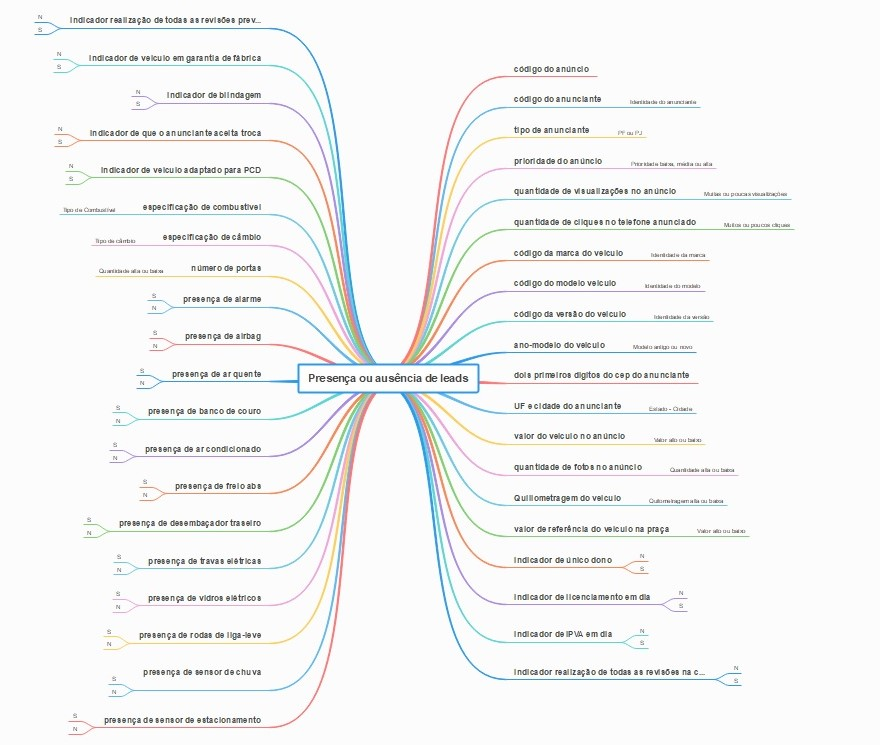

In [84]:
# Imagem do mapa de hipóteses
Image( 'Images/Presença ou ausencia de leads.jpg' )

## 4.6 Engenharia de Recursos

Neste tópico, a fim de melhorar o desempenho final dos modelos de Machine Learning com novas informações a qual não tive acesso e ter bons resultados, foram criados 3 novas varíaveis:
* **Quantidade de Anúncio por Código** - Divide a quantidade de códigos de anunciantes por categoria. Os que anunciam pouco, os que anunciam médio e os que anunciam muito.

* **Quantidade de Marca do Anúncio** - Divide a quantidade de marcas do veículo  por categoria. As que são anunciadas pouco, as que são anunciadas médio e as que são anunciadas muito.

* **Quantidade de Versão do Anúncio** - Divide a quantidade de versões do veículo  por categoria. As que são anunciadas pouco, as que são anunciadas médio e as que são anunciadas muito.
    

### 4.6.1 Carregando

In [85]:
# Carregar o data set
data1 = pd.read_csv('Data_saves/data_clean.csv', low_memory=False)

# checar a dimensão do data set 
data1.shape

(42448, 43)

### 4.6.2 Criando Recursos

In [86]:
# Criando quantidade de anúncio por código
data_1 = data_anuncio(data1)

data_1['Nivel_Anuncio'] = ''
for idx, _ in data_1.iterrows():
    if (data_1['QTDE_Anuncios'].at[idx]<10):
        data_1['Nivel_Anuncio'].at[idx]='Pouco Anúncio'
    elif (data_1['QTDE_Anuncios'].at[idx]>=10) & (data_1['QTDE_Anuncios'].at[idx]<30):
        data_1['Nivel_Anuncio'].at[idx]='Médio Anúncio'
    else:
        data_1['Nivel_Anuncio'].at[idx]='Muito Anúncio'


data1 = pd.merge(left = data1, right = data_1[["código_do_anunciante1", "Nivel_Anuncio"]], how = "left", left_on = "código_do_anunciante", right_on = "código_do_anunciante1")
data1.drop(columns=['código_do_anunciante1'], inplace = True)


# Criando quantidade de marca de anúncio
data__1 = data_marca(data)

data__1['Marca_Anuncio'] = ''
for idx, _ in data__1.iterrows():
    if (data__1['QTDE_Marca'].at[idx]<100):
        data__1['Marca_Anuncio'].at[idx]='Pouco Anúncio'
    elif (data__1['QTDE_Marca'].at[idx]>=100) & (data__1['QTDE_Marca'].at[idx]<1000):
        data__1['Marca_Anuncio'].at[idx]='Médio Anúncio'
    else:
        data__1['Marca_Anuncio'].at[idx]='Muito Anúncio'


data1 = pd.merge(left = data1, right = data__1[["cod_marca_veiculo1", "Marca_Anuncio"]], how = "left", left_on = "cod_marca_veiculo", right_on = "cod_marca_veiculo1")
data1.drop(columns=['cod_marca_veiculo1'], inplace = True)


# Criando quantidade de versão de anúncio
data___1 = data_versao(data1)

data___1['Versao_Anuncio'] = ''
for idx, _ in data___1.iterrows():
    if (data___1['QTDE_Marca'].at[idx]<20):
        data___1['Versao_Anuncio'].at[idx]='Pouco Anúncio'
    elif (data___1['QTDE_Marca'].at[idx]>=20) & (data___1['QTDE_Marca'].at[idx]<100):
        data___1['Versao_Anuncio'].at[idx]='Médio Anúncio'
    else:
        data___1['Versao_Anuncio'].at[idx]='Muito Anúncio'


data1 = pd.merge(left = data1, right = data___1[["cod_versao_veiculo1", "Versao_Anuncio"]], how = "left", left_on = "cod_versao_veiculo", right_on = "cod_versao_veiculo1")
data1.drop(columns=['cod_versao_veiculo1'], inplace = True)


# Removendo códigos dos anúncios por ser inútel
data1.drop(columns=['cod_anuncio'], inplace = True)

# Criando variável se tem leads ou não
data1['leads_class'] = ''
for idx, _ in data1.iterrows():
    if (data1['leads'].at[idx]>0) :
        data1['leads_class'].at[idx]=1
    else:
        data1['leads_class'].at[idx]=0 

### 4.6.3 Checkpoint

In [87]:
# salvar o data set 
data1.to_csv('Data_saves/data1_f.csv', index=False)

# 5 Questões e Hipóteses

**1**. A quantidade de leads do Rio de Janeiro mantém a mesma posição(2º) do somatório de leads por Estado.

**2**. A ordem de quantidade de leads por cidade é o mesmo do somatório de leads.

**3**. Pessoa Jurídica tem mais somatório de leads que Pessoa Física.

**4**. Anúncio com alta prioridade tem mais somatório de leads devido à urgência na venda.


# 6 Análise Exploratória dos Dados

## 6.1 Análises Univariadas

### 6.1.1 Variável Alvo

Nesse gráfico, a quantidade de leads foi dividida em **sim** ( houve leads) e **não** ( não houve leads) para seguir com o projeto a aplicar os modelos de Machine Learning.

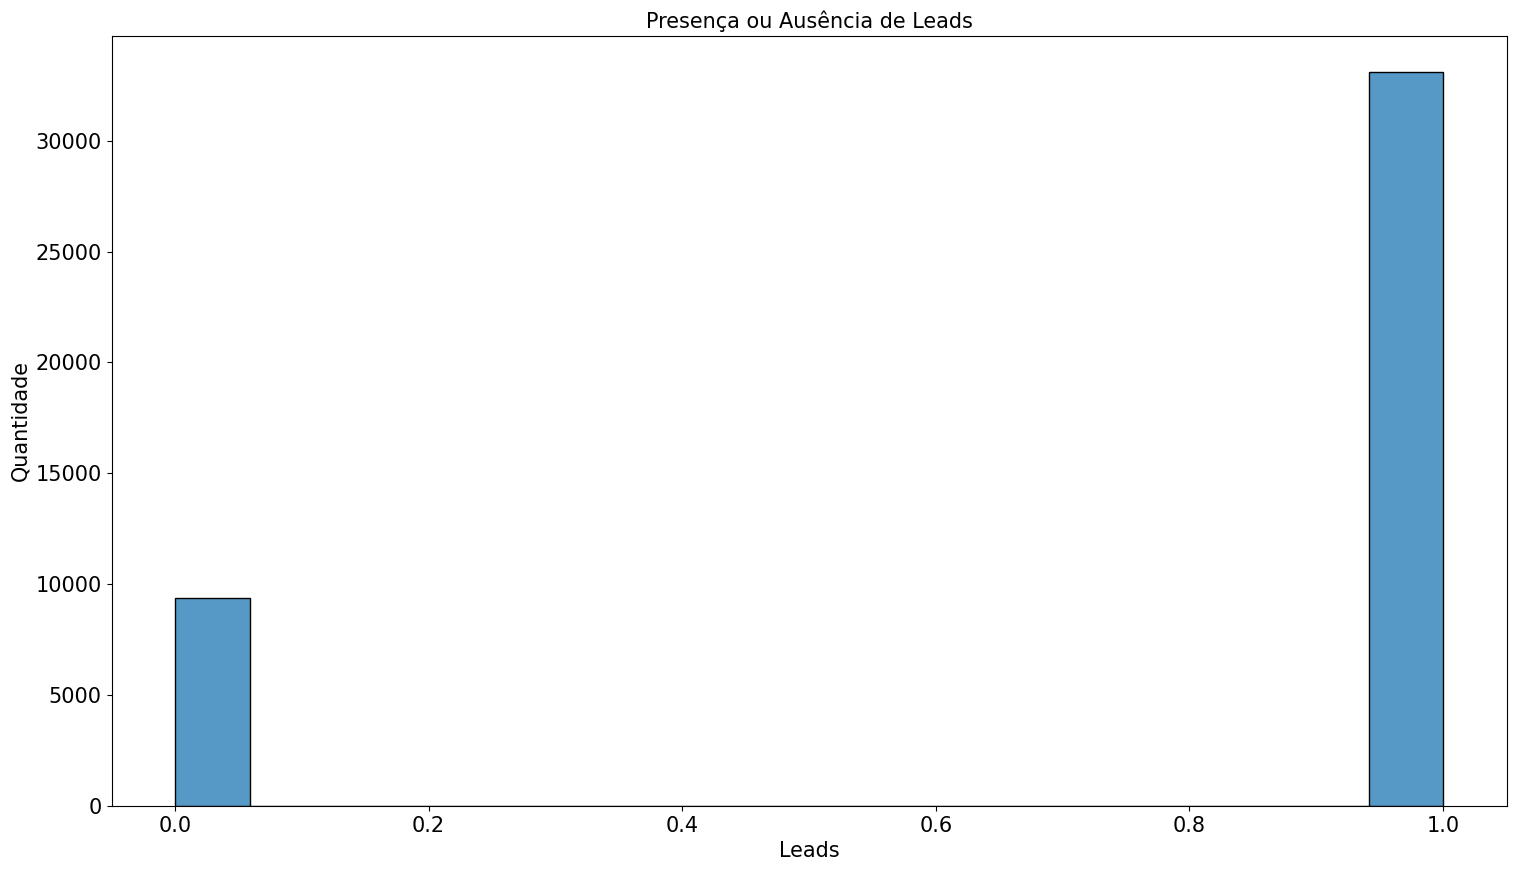

In [90]:
plt.figure(figsize=(18,10))
ax1 = sns.histplot(x=data1['leads_class'])
data_load(ax1,'Presença ou Ausência de Leads', 'Leads','Quantidade' )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

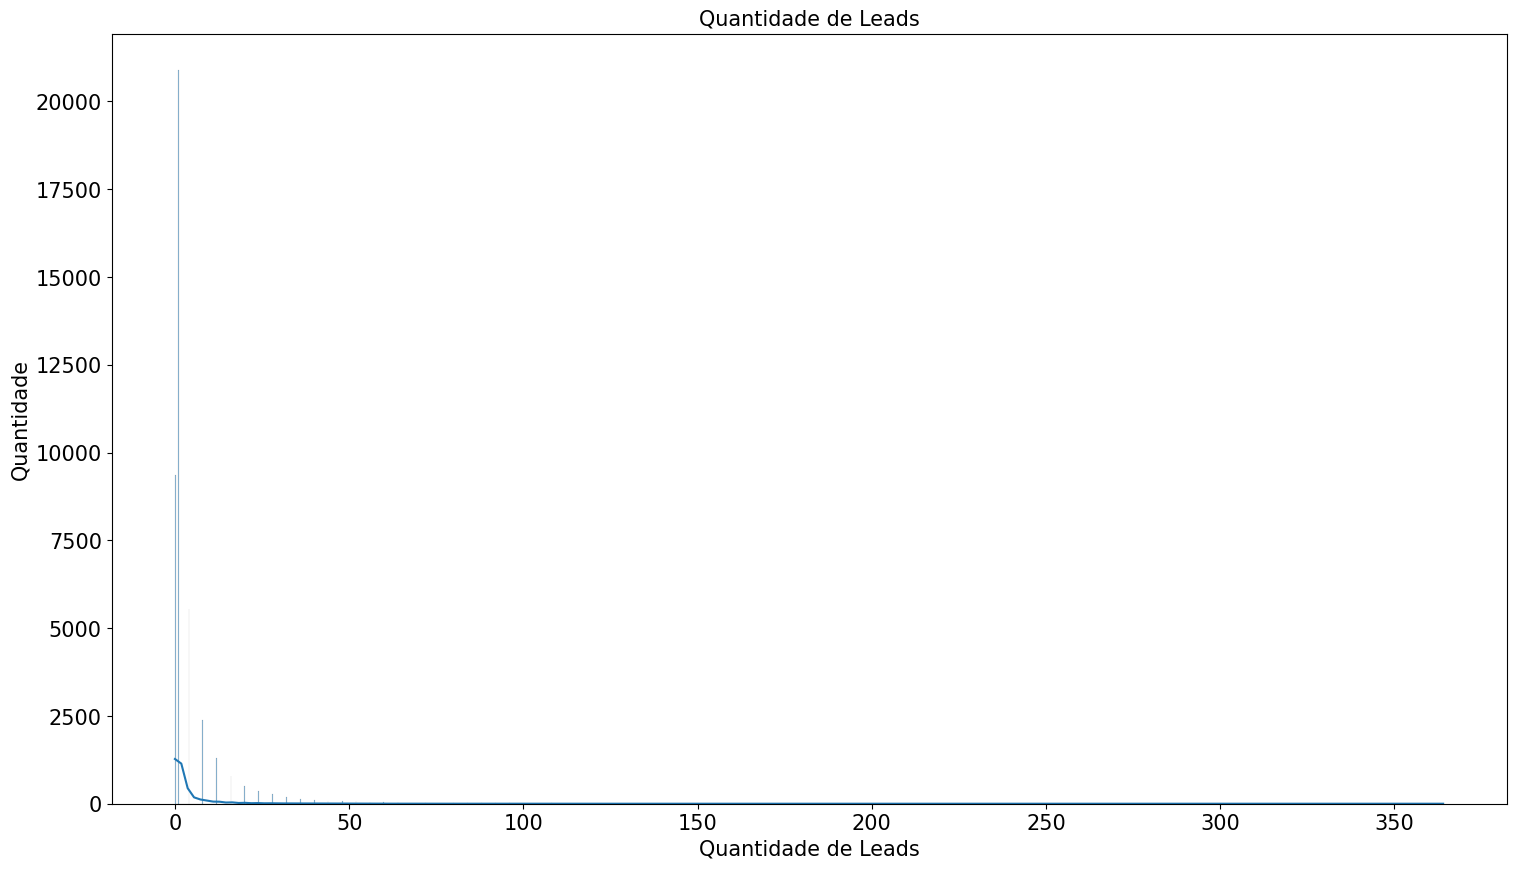

In [91]:
plt.figure(figsize=(18,10))
ax1 = sns.histplot(x=data1['leads'], kde=True)
data_load(ax1,'Quantidade de Leads', 'Quantidade de Leads','Quantidade' )

plt.subplots_adjust(hspace=0.3)  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

### 6.1.2 Variável Numérica

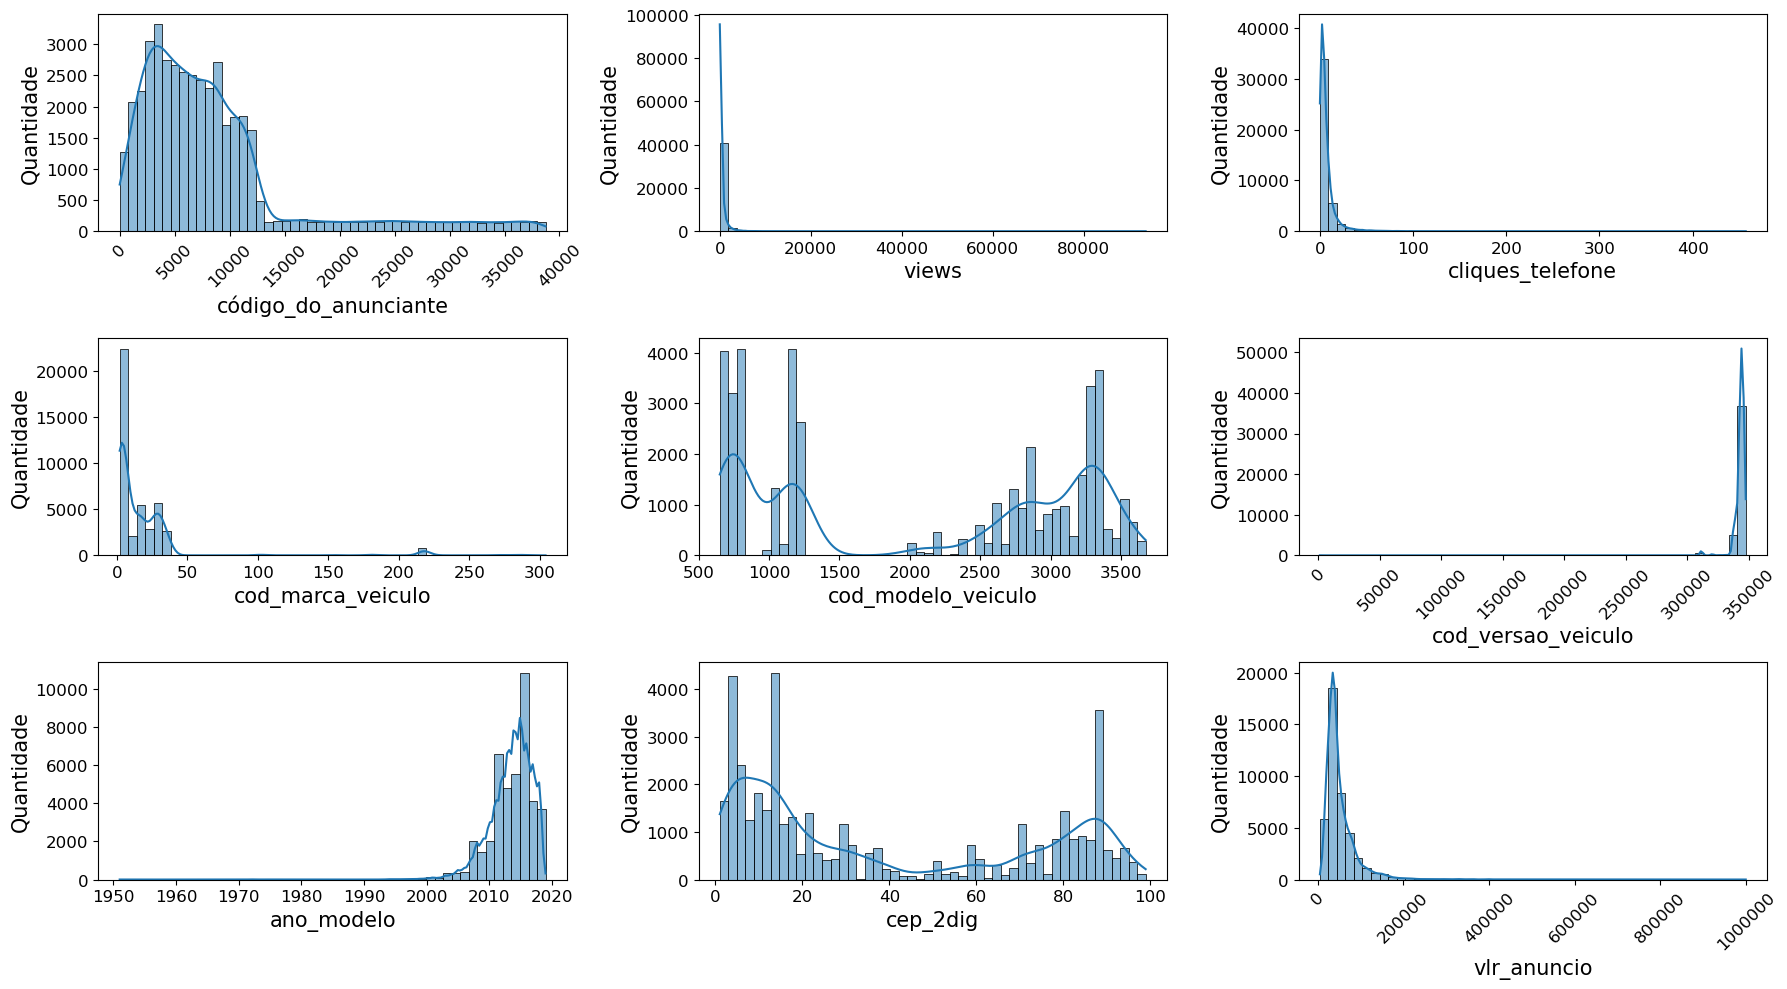

In [101]:
plt.figure(figsize=(18,10))

# Código do anunciante
plt.subplot(3,3,1)
ax1 = sns.histplot(x=data1['código_do_anunciante'],bins=50, kde=True)
data_load(ax1,'', 'código_do_anunciante','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Views
plt.subplot(3,3,2)
ax2 = sns.histplot(x=data1['views'],bins=50, kde=True)
data_load(ax2,'', 'views','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Cliques telefone
plt.subplot(3,3,3)
ax3 = sns.histplot(x=data1['cliques_telefone'],bins=50, kde=True)
data_load(ax3,'', 'cliques_telefone','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Código marca veículo
plt.subplot(3,3,4)
ax4 = sns.histplot(x=data1['cod_marca_veiculo'],bins=50, kde=True)
data_load(ax4,'', 'cod_marca_veiculo','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Código modelo veículo
plt.subplot(3,3,5)
ax5 = sns.histplot(x=data1['cod_modelo_veiculo'],bins=50, kde=True)
data_load(ax5,'', 'cod_modelo_veiculo','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Código versão veículo
plt.subplot(3,3,6)
ax6 = sns.histplot(x=data1['cod_versao_veiculo'],bins=50, kde=True)
data_load(ax6,'', 'cod_versao_veiculo','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ano modelo
plt.subplot(3,3,7)
ax7 = sns.histplot(x=data1['ano_modelo'],bins=50, kde=True)
data_load(ax7,'', 'ano_modelo','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# CEP
plt.subplot(3,3,8)
ax8 = sns.histplot(x=data1['cep_2dig'],bins=50, kde=True)
data_load(ax8,'', 'cep_2dig','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Valor anúncio
plt.subplot(3,3,9)
ax9 = sns.histplot(x=data1['vlr_anuncio'],bins=50, kde=True)
data_load(ax9,'', 'vlr_anuncio','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax9.ticklabel_format(style='plain', axis='x')

ax1.tick_params(axis='x', rotation=45)
ax6.tick_params(axis='x', rotation=45)
ax9.tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.3)  

plt.tight_layout()
    
plt.show()

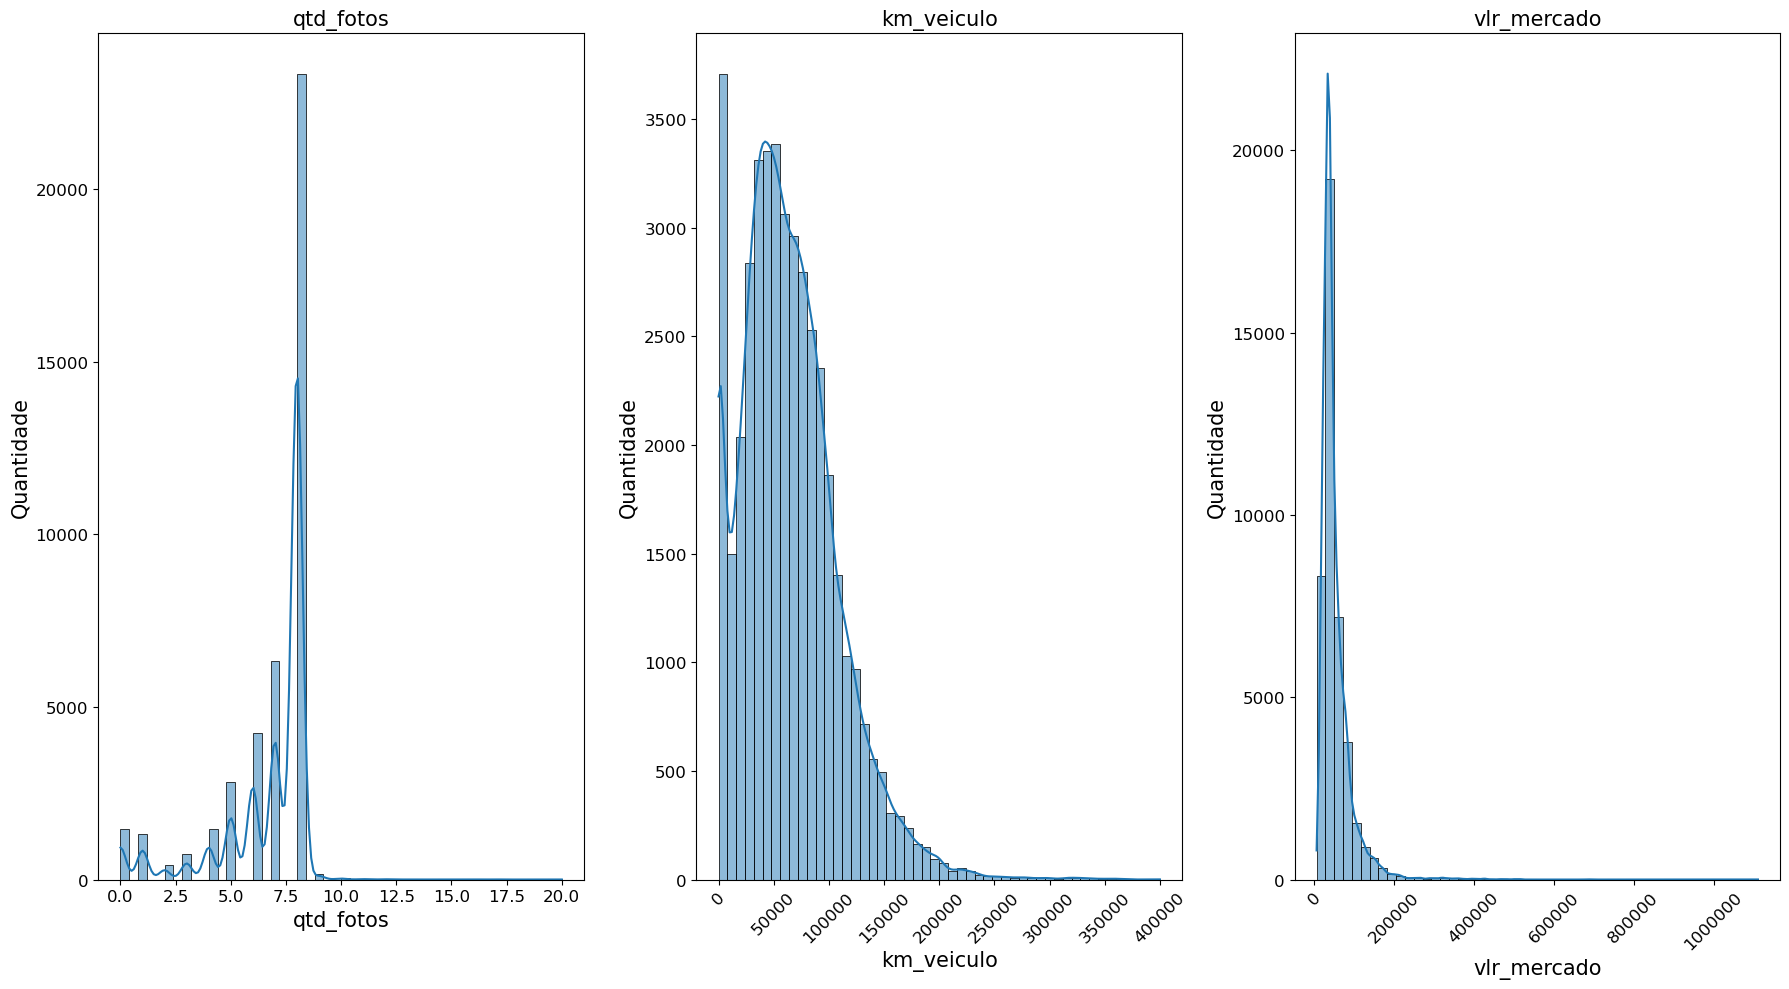

In [102]:
plt.figure(figsize=(18,10))

# Quantidade de fotos
plt.subplot(1,3,1)
ax1 = sns.histplot(x=data1['qtd_fotos'],bins=50, kde=True)
data_load(ax1,'qtd_fotos', 'qtd_fotos','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# KM do veículo
plt.subplot(1,3,2)
ax2 = sns.histplot(x=data1['km_veiculo'],bins=50, kde=True)
data_load(ax2,'km_veiculo', 'km_veiculo','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Valor de mercado
plt.subplot(1,3,3)
ax3 = sns.histplot(x=data1['vlr_mercado_2'],bins=50, kde=True)
data_load(ax3,'vlr_mercado', 'vlr_mercado','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax3.ticklabel_format(style='plain', axis='x')

ax2.tick_params(axis='x', rotation=45)
ax3.tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.3)  

plt.tight_layout()
    
plt.show()

### 6.1.3 Variável Categórica

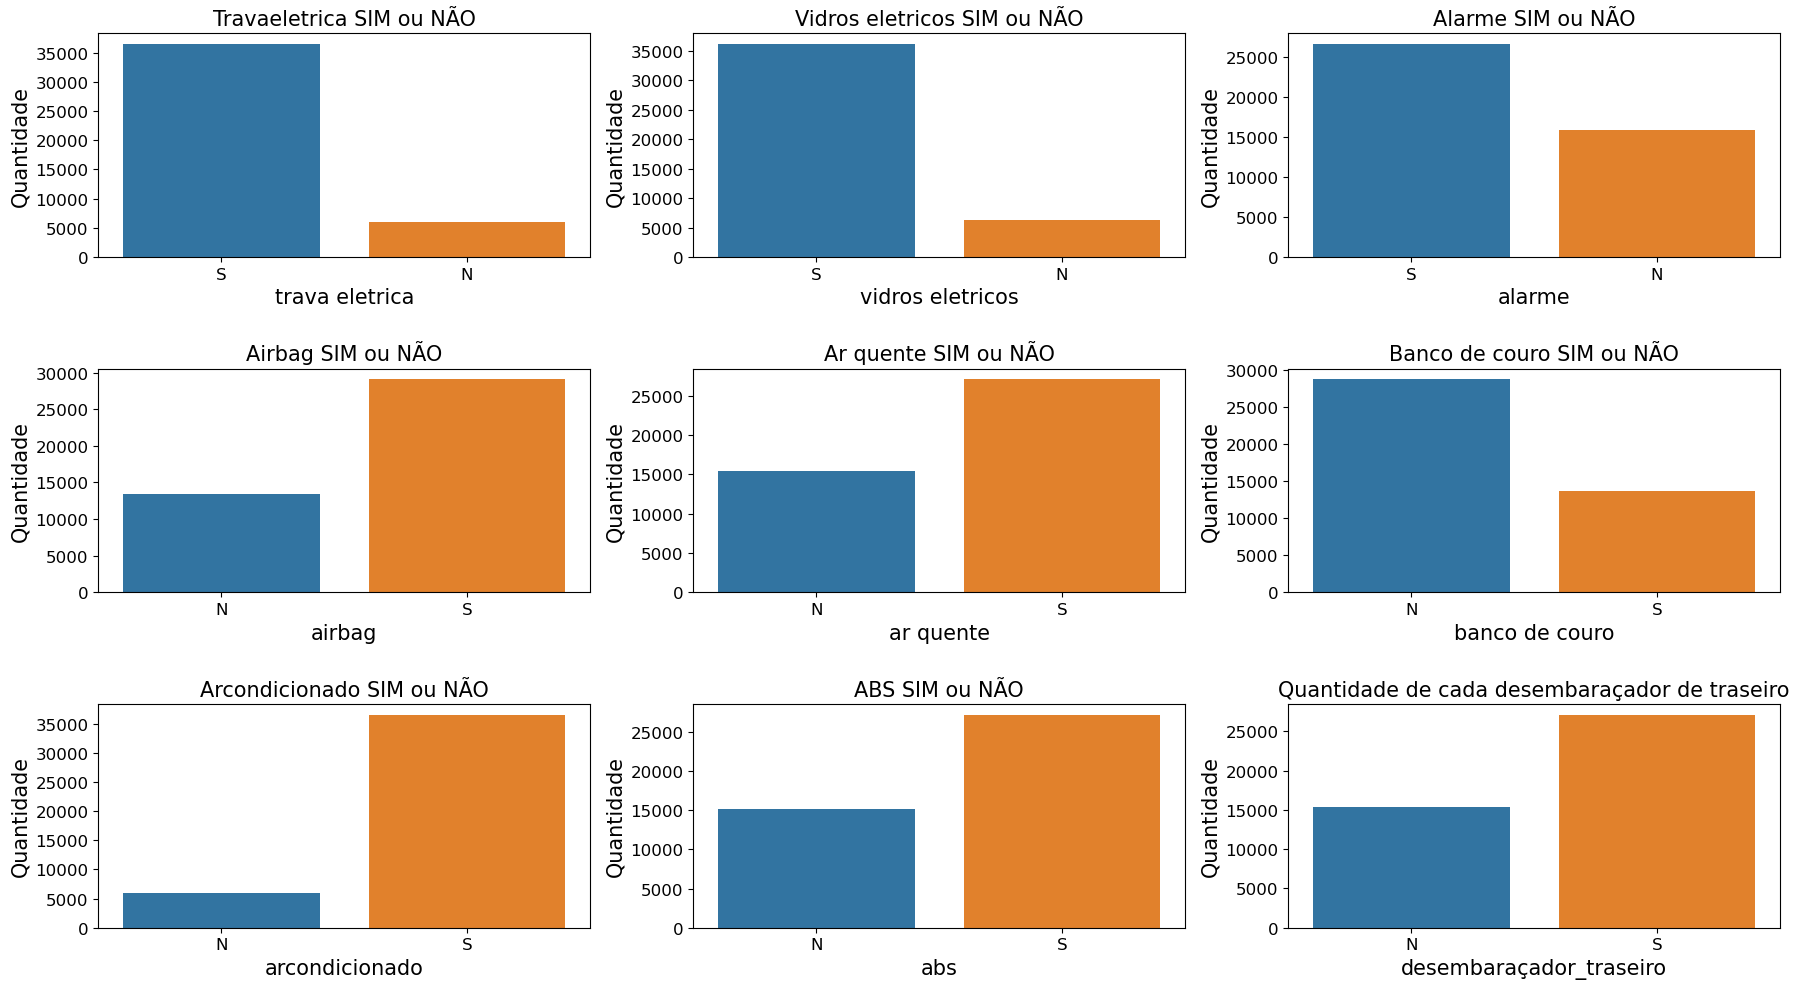

In [103]:
plt.figure(figsize=(18, 10))

# Gênero
plt.subplot(3,3,1)
ax1 = sns.countplot(x=data1['travaeletrica'])
data_load(ax1,'Travaeletrica SIM ou NÃO', 'trava eletrica','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Colesterol
plt.subplot(3,3,2)
ax2 = sns.countplot(x=data1['vidroseletricos'])
data_load(ax2,'Vidros eletricos SIM ou NÃO', 'vidros eletricos','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Glicose
plt.subplot(3,3,3)
ax3 = sns.countplot(x=data1['alarme'])
data_load(ax3,'Alarme SIM ou NÃO', 'alarme','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Fuma
plt.subplot(3,3,4)
ax4 = sns.countplot(x=data1['airbag'])
data_load(ax4,'Airbag SIM ou NÃO', 'airbag','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Álcool
plt.subplot(3,3,5)
ax5 = sns.countplot(x=data1['arquente'])
data_load(ax5,'Ar quente SIM ou NÃO', 'ar quente','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Atividade física
plt.subplot(3,3,6)
ax6 = sns.countplot(x=data1['bancocouro'])
data_load(ax6,'Banco de couro SIM ou NÃO', 'banco de couro','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Presença ou ausência de doença cardiovascular
plt.subplot(3,3,7)
ax7 = sns.countplot(x=data1['arcondicionado'])
data_load(ax7,'Arcondicionado SIM ou NÃO', 'arcondicionado','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# TabelaPressões
plt.subplot(3,3,8)
ax8 = sns.countplot(x=data1['abs'])
data_load(ax8,'ABS SIM ou NÃO', 'abs','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# TabelaIMC
plt.subplot(3,3,9)
ax9 = sns.countplot(x=data1['desembaraçador_traseiro'])
data_load(ax9,'Quantidade de cada desembaraçador de traseiro', 'desembaraçador_traseiro','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
  
plt.show()    

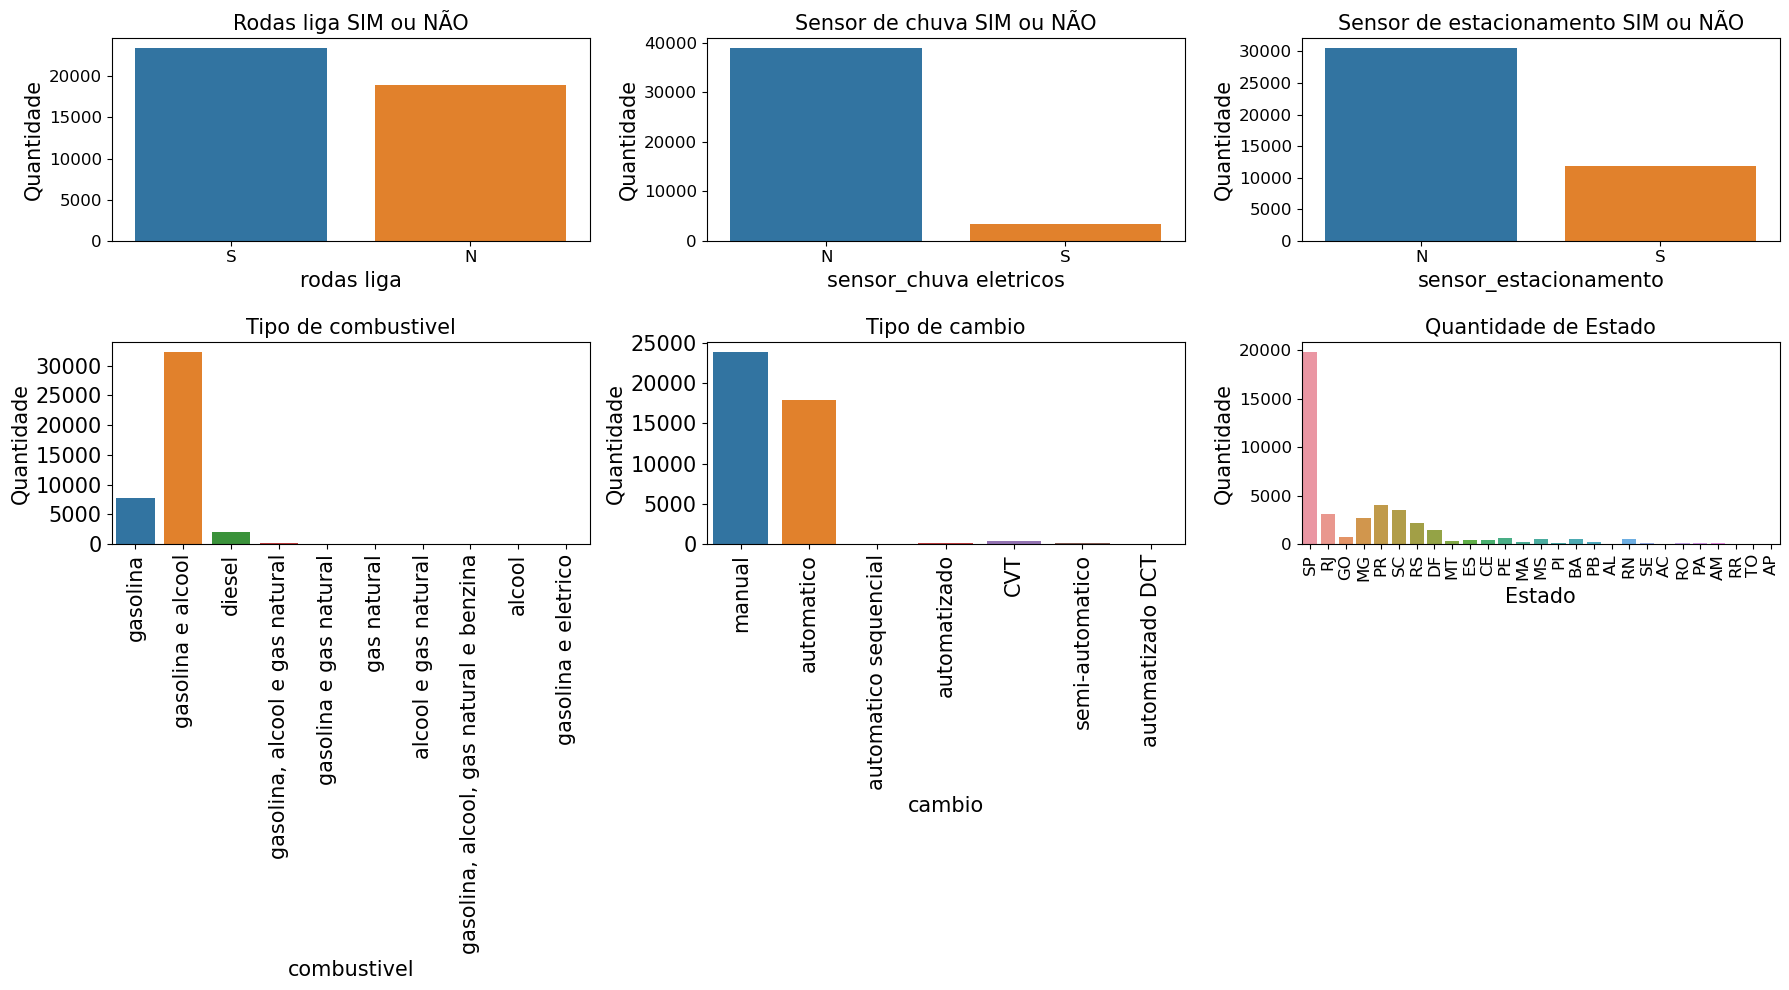

In [113]:
plt.figure(figsize=(18, 10))

# Rodas liga
plt.subplot(2,3,1)
ax1 = sns.countplot(x=data1['rodasliga'])
data_load(ax1,'Rodas liga SIM ou NÃO', 'rodas liga','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Sensor de chuva
plt.subplot(2,3,2)
ax2 = sns.countplot(x=data1['sensor_chuva'])
data_load(ax2,'Sensor de chuva SIM ou NÃO', 'sensor_chuva eletricos','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Sensor de Estacionamento
plt.subplot(2,3,3)
ax3 = sns.countplot(x=data1['sensor_estacionamento'])
data_load(ax3,'Sensor de estacionamento SIM ou NÃO', 'sensor_estacionamento','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tipo de combustível
plt.subplot(2,3,4)
ax4 = sns.countplot(x=data1['combustivel'])
data_load(ax4,'Tipo de combustivel', 'combustivel','Quantidade' )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Tipo de câmbio
plt.subplot(2,3,5)
ax5 = sns.countplot(x=data1['cambio'])
data_load(ax5,'Tipo de cambio', 'cambio','Quantidade' )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#Quantidade de estado
plt.subplot(2,3,6)
ax6 = sns.countplot(x=data1['Estado'])
data_load(ax6,'Quantidade de Estado', 'Estado','Quantidade' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax4.tick_params(axis='x', rotation=90)

ax5.tick_params(axis='x', rotation=90)

ax6.tick_params(axis='x', rotation=90)

plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
  
plt.show() 

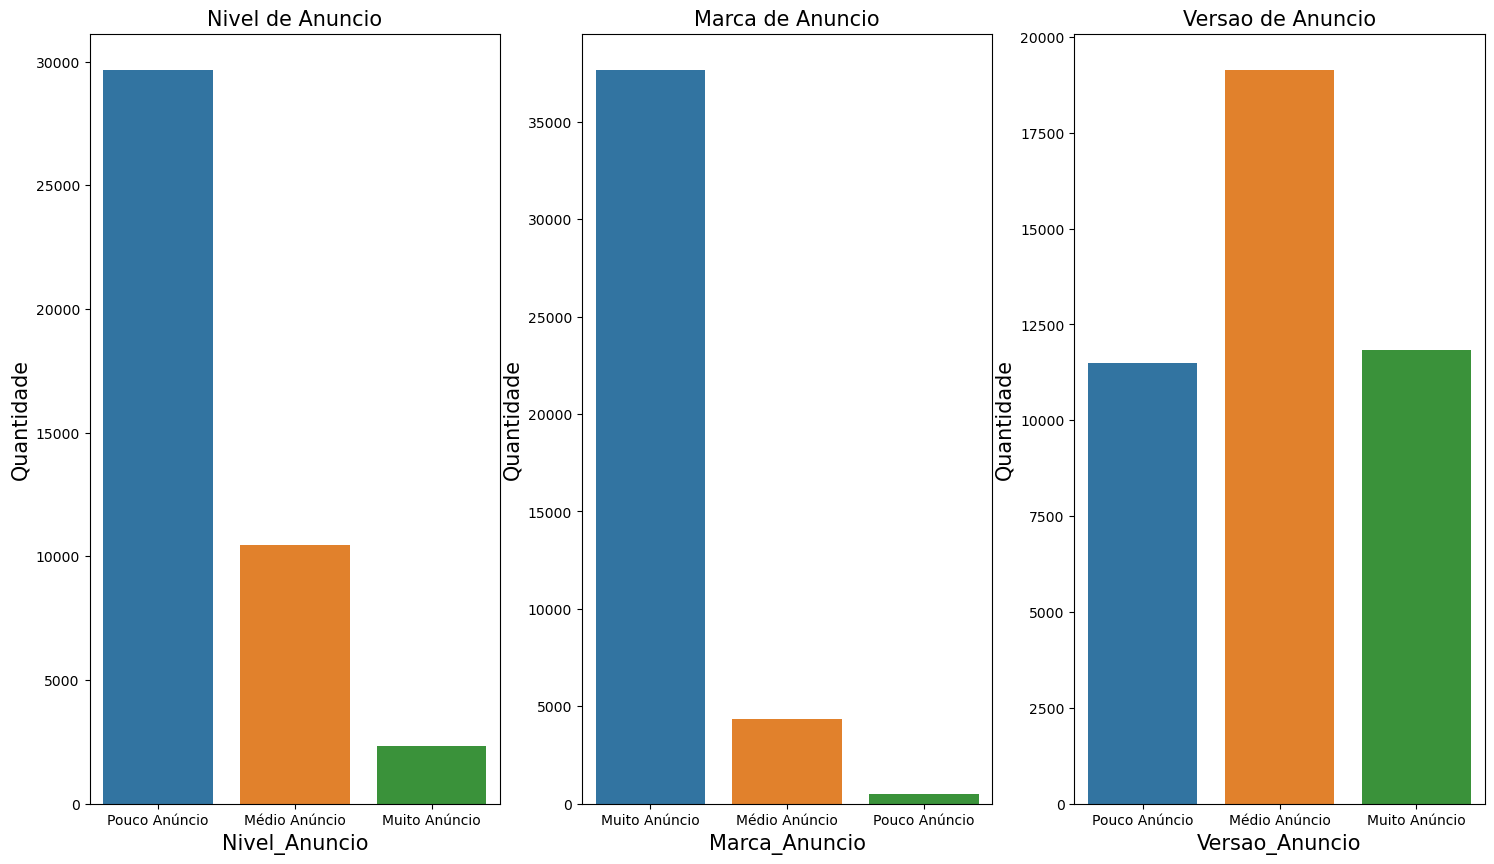

In [114]:
plt.figure(figsize=(18, 10))

# Nível anúncio
plt.subplot(1,3,1)
ax1 = sns.countplot(x=data1['Nivel_Anuncio'])
data_load(ax1,'Nivel de Anuncio', 'Nivel_Anuncio','Quantidade' )

# Marca anúncio
plt.subplot(1,3,2)
ax2 = sns.countplot(x=data1['Marca_Anuncio'])
data_load(ax2,'Marca de Anuncio', 'Marca_Anuncio','Quantidade' )

# Versão anúncio
plt.subplot(1,3,3)
ax3 = sns.countplot(x=data1['Versao_Anuncio'])
data_load(ax3,'Versao de Anuncio', 'Versao_Anuncio','Quantidade' )

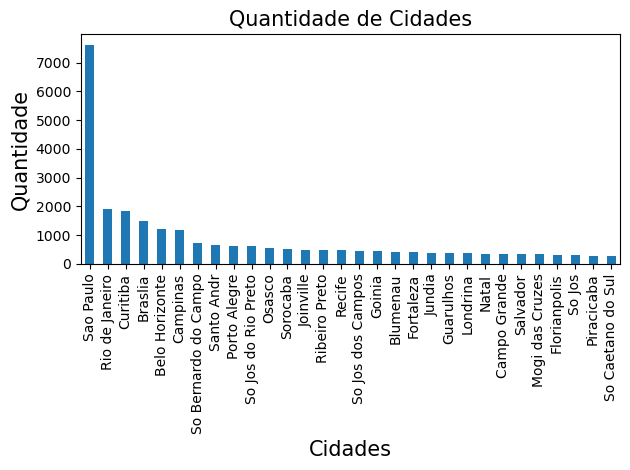

In [115]:
nome_correct(data)

data_plot = data1["Cidade"].value_counts()

plt.subplot(1,1,1)
ax = data_plot.head(30).plot.bar()
data_load(ax,'Quantidade de Cidades', 'Cidades','Quantidade' )

plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
  
plt.show() 

## 6.2 Análises Bivariadas

## HIPÓTESE 1
A quantidade de leads do Rio de Janeiro mantém a mesma posição(2º) do somatório de leads por Estado. - **FALSO**

* Obersamos que num único anúncio, o estado do Rio de Janeiro(2º) possui, em média, mais leads que o Paraná por exemplo, mas tem menos quantidade de anúncio. Precisamos melhorar o desempenho no Paraná e aumentar a quantidade de anúncio no Rio de Janeiro.

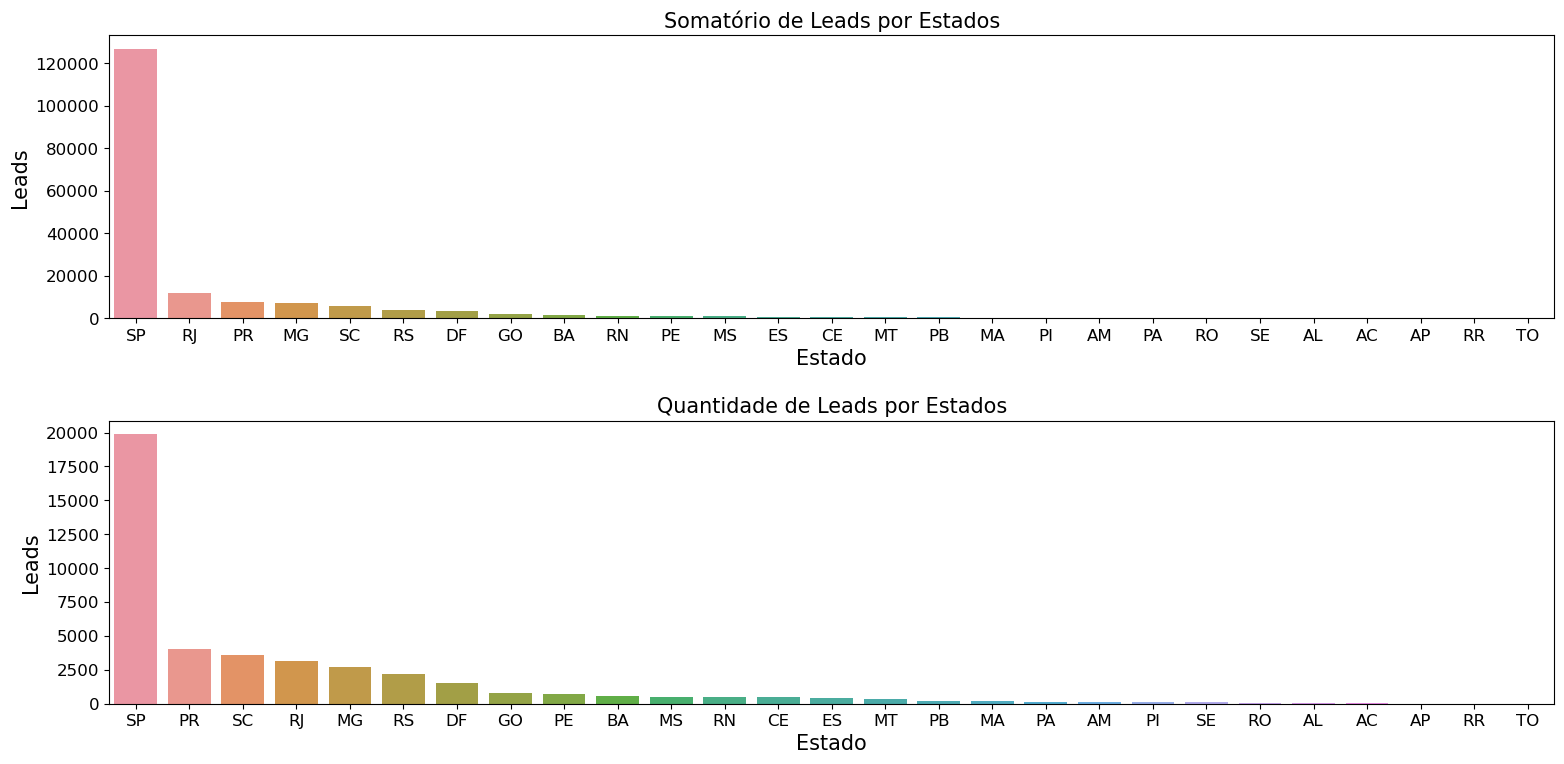

In [118]:
data_estado = data1[['leads', 'Estado']].groupby('Estado').sum().sort_values(by=['leads'], ascending=False).reset_index()
data_estado1 = data1[['leads', 'Estado']].groupby('Estado').count().sort_values(by=['leads'], ascending=False).reset_index()

plt.figure(figsize=(16,8), tight_layout={'pad':2.0})

plt.subplot(2,1,1)
ax1 = sns.barplot(data = data_estado, x='Estado', y='leads')
data_load(ax1,'Somatório de Leads por Estados', 'Estado','Leads' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,1,2)
ax2 = sns.barplot(data = data_estado1, x='Estado', y='leads')
data_load(ax2,'Quantidade de Leads por Estados', 'Estado','Leads' )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(hspace=0.5)
  
plt.show() 

## HIPÓTESE 2
A ordem de quantidade de leads por cidade é o mesmo do somatório de leads. - **FALSO**

* Obersamos que a cidade de **Campinas** é o 3º em somatório de leads, mas não está no ranking das 5 cidades em quantidade de leads. Precisamos melhorar os anúncios de algumas cidades como **Curitiba**, **Brasília** e **Belo Horizonte**, além de fazer mais anúncios em **Campinas**. 

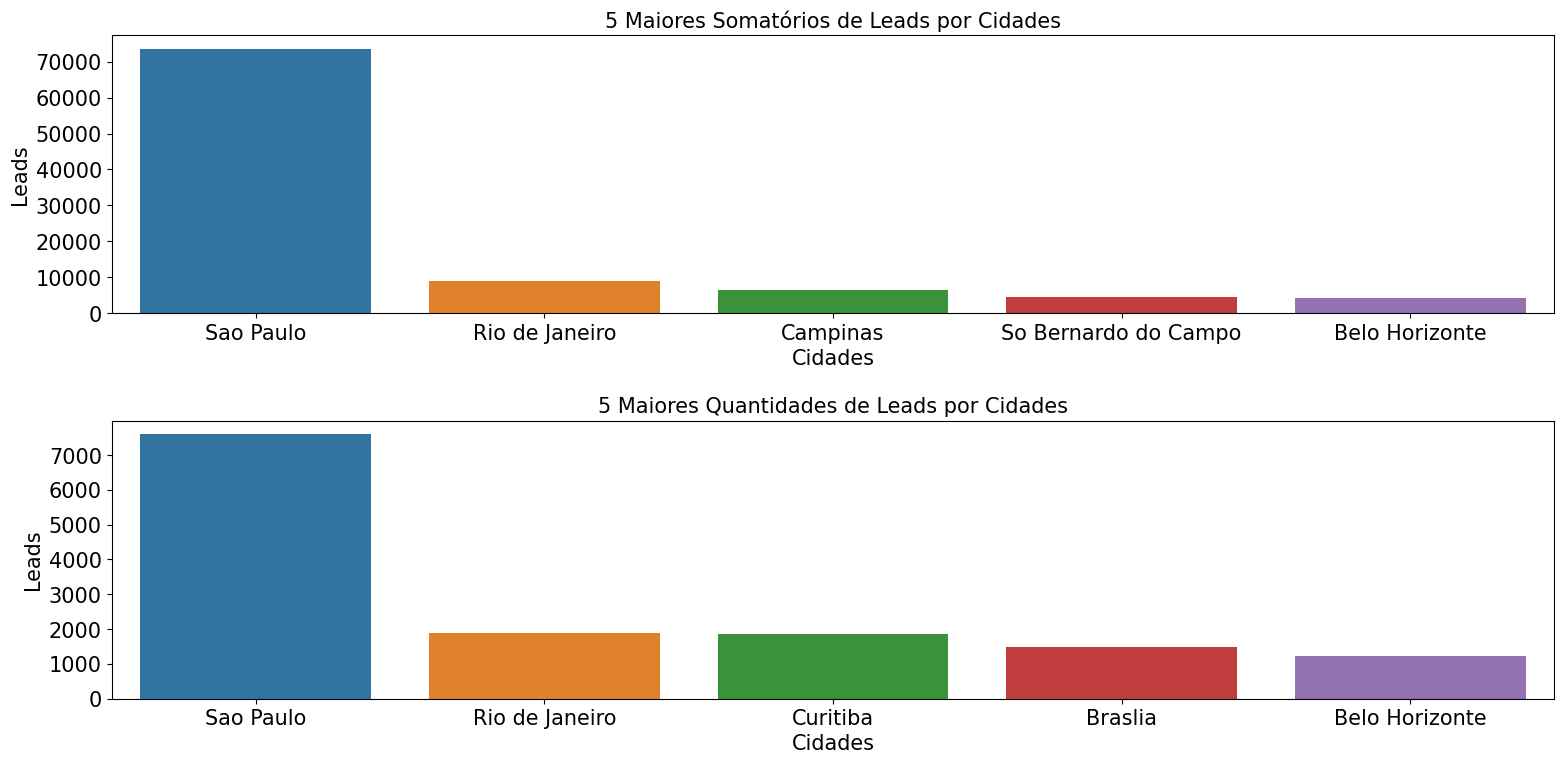

In [120]:
data_cidade = data1[[ 'Cidade','leads']].groupby('Cidade').sum().sort_values(by=['leads'], ascending=False).reset_index()
data_cidade1 = data1[['leads', 'Cidade']].groupby('Cidade').count().sort_values(by=['leads'], ascending=False).reset_index()

plt.figure(figsize=(16,8), tight_layout={'pad':2.0})

plt.subplot(2,1,1)
ax1 = sns.barplot(data = data_cidade.head(), x='Cidade', y='leads')
data_load(ax1,'5 Maiores Somatórios de Leads por Cidades', 'Cidades','Leads' )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,1,2)
ax2 = sns.barplot(data = data_cidade1.head(), x='Cidade', y='leads')
data_load(ax2,'5 Maiores Quantidades de Leads por Cidades', 'Cidades','Leads' )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)



plt.subplots_adjust(hspace=0.5)
  
plt.show()

## HIPÓTESE 3
Pessoa Jurídica tem mais somatório de leads que Pessoa Física. - **VERDADEIRO**

* Observamos que é verdade. Mesmo assim, precisamos melhorar o desempenho dos anúncios de **Pessoa Jurídica**, pois possui muitos anúncios, mas em somatórios, a proporçaõ é menor.

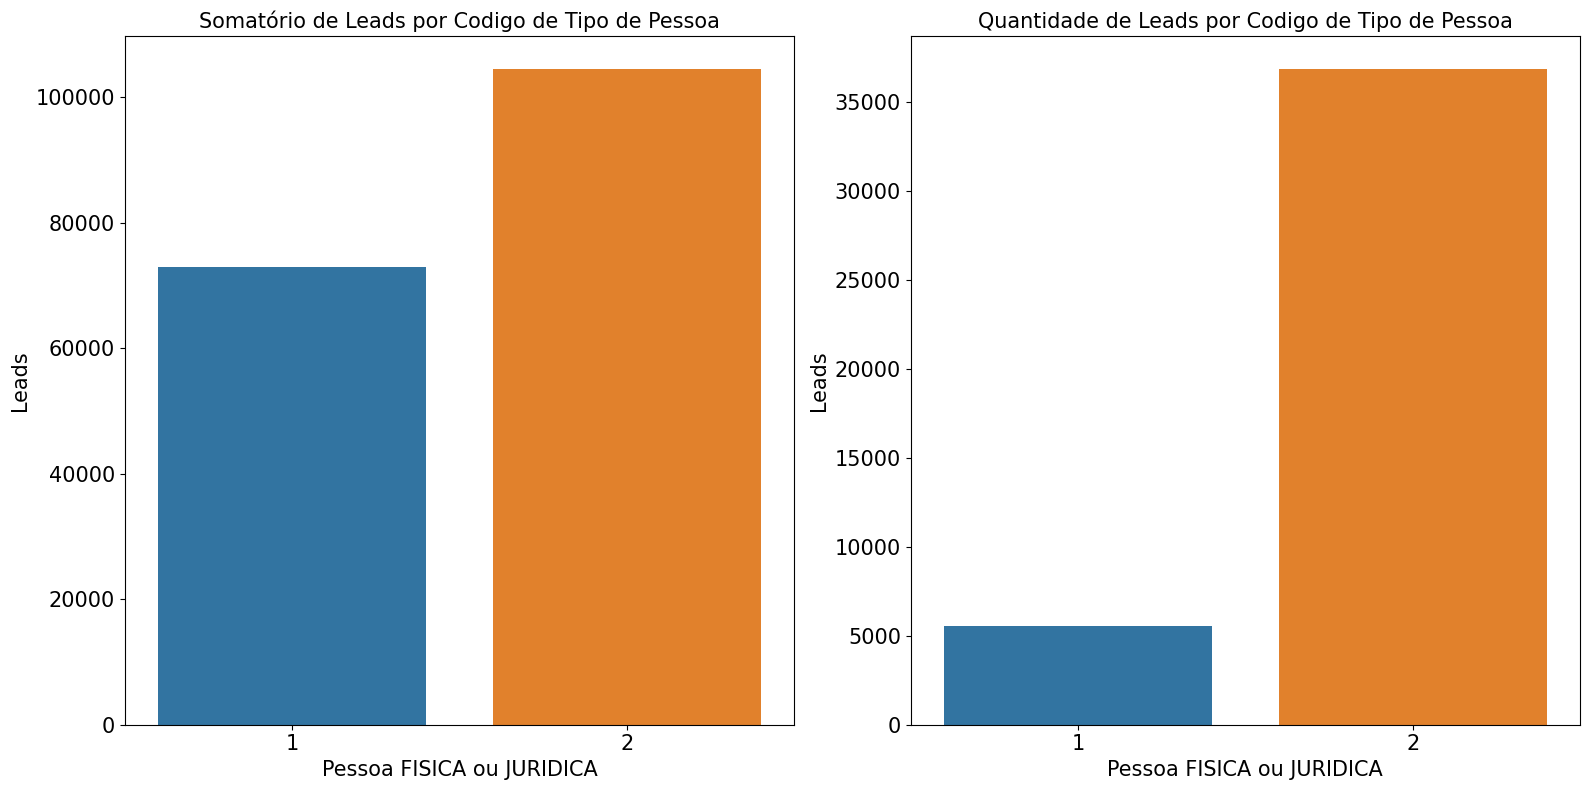

In [121]:
data_cod_tipo_pessoa = data1[['cod_tipo_pessoa', 'leads']].groupby('cod_tipo_pessoa').sum().sort_values(by=['leads'], ascending=False).reset_index()
data_cod_tipo_pessoa1 = data1[['cod_tipo_pessoa', 'leads']].groupby('cod_tipo_pessoa').count().sort_values(by=['leads'], ascending=False).reset_index()

plt.figure(figsize=(16,8), tight_layout={'pad':2.0})

plt.subplot(1,2,1)
ax1 = sns.barplot(data = data_cod_tipo_pessoa, x='cod_tipo_pessoa', y='leads')
data_load(ax1,'Somatório de Leads por Codigo de Tipo de Pessoa', 'Pessoa FISICA ou JURIDICA','Leads' )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(1,2,2)
ax2 = sns.barplot(data = data_cod_tipo_pessoa1, x='cod_tipo_pessoa', y='leads')
data_load(ax2,'Quantidade de Leads por Codigo de Tipo de Pessoa', 'Pessoa FISICA ou JURIDICA','Leads' )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
  
plt.show()

## HIPÓTESE 4
Anúncio com alta prioridade tem mais somatório de leads devido à urgência na venda. - **FALSO**

* Percebemos que é falso, pois anúncios com baixa prioridade tem mais somatório de leads. Independente disso, a proporção de prioridades é parecida quando comparada quantidade de leads e somatório de leads. Precisamos ter mais anúncios em ambas para obter mais leads.

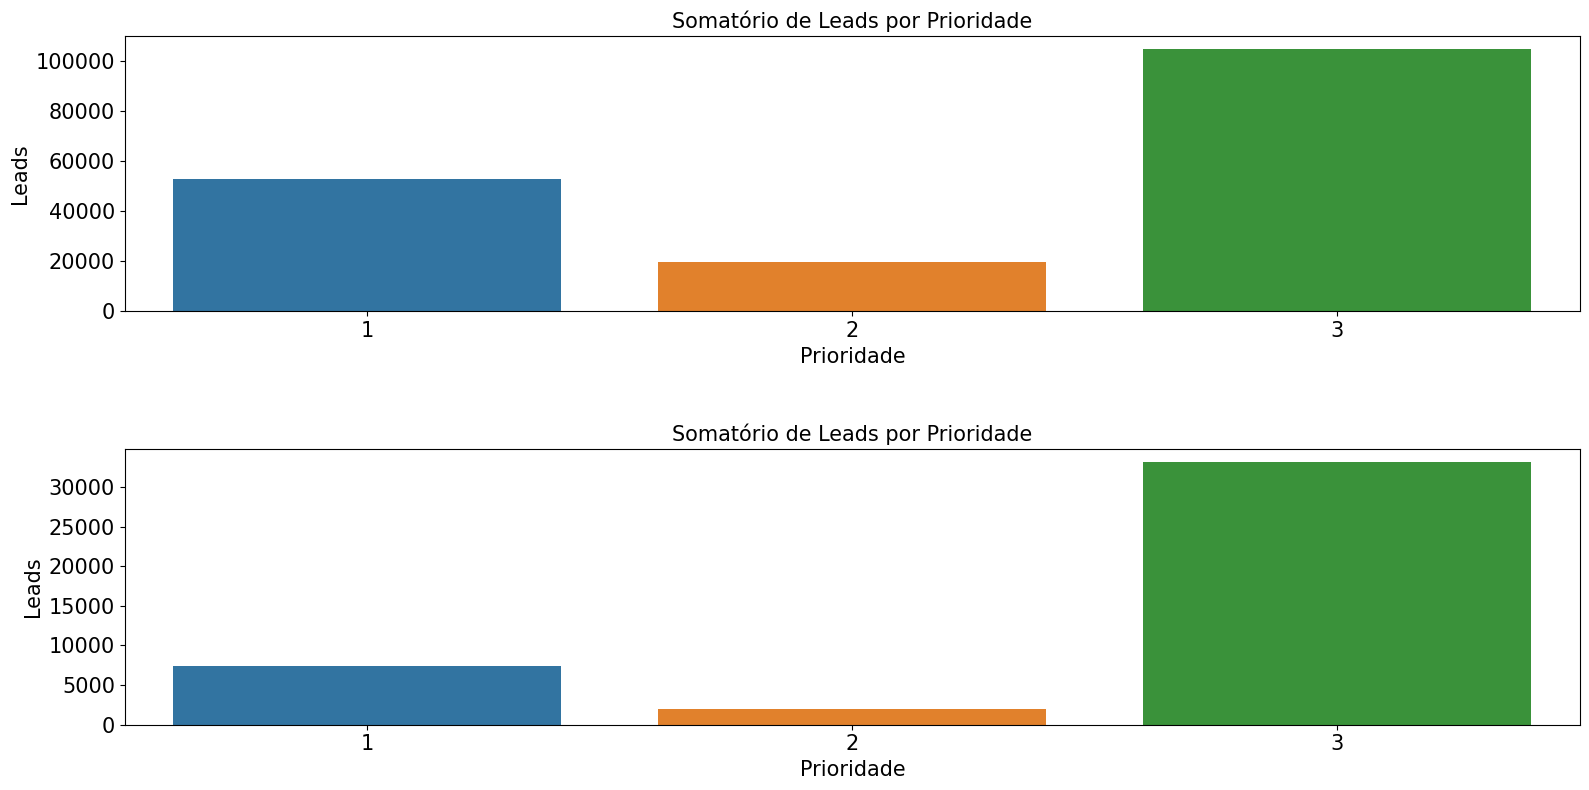

In [122]:
data_prioridade = data1[['prioridade', 'leads']].groupby('prioridade').sum().sort_values(by=['leads'], ascending=False).reset_index()
data_prioridade1 = data1[['prioridade', 'leads']].groupby('prioridade').count().sort_values(by=['leads'], ascending=False).reset_index()

plt.figure(figsize=(16,8), tight_layout={'pad':2.0})

plt.subplot(2,1,1)
ax1 = sns.barplot(data = data_prioridade, x='prioridade', y='leads')
data_load(ax1,'Somatório de Leads por Prioridade', 'Prioridade','Leads' )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,1,2)
ax1 = sns.barplot(data = data_prioridade1, x='prioridade', y='leads')
data_load(ax1,'Somatório de Leads por Prioridade', 'Prioridade','Leads' )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
  
plt.show()

### 6.2.1 Visão Global das Hipóteses


In [123]:
tab =[['Hypothesis', 'Conclusion', 'Relevance', 'Discover'],
      ['H1', 'Falso', 'Alto', 'A quantidade de leads do Rio de Janeiro mantém a mesma posição(2º) do somatório de leads por Estado.'],  
      ['H2', 'Falso', 'Alto', 'A ordem de quantidade de leads por cidade é o mesmo do somatório de leads. '],  
      ['H3', 'Verdadeiro', 'Alto', 'Pessoa Jurídica tem mais somatório de leads que Pessoa Física.'],
      ['H4', 'Falso', 'Médio', 'Anúncio com alta prioridade tem mais somatório de leads devido à urgência na venda.'],
     ]

print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance    Discover
------------  ------------  -----------  ----------------------------------------------------------------------------------------------------
H1            Falso         Alto         A quantidade de leads do Rio de Janeiro mantém a mesma posição(2º) do somatório de leads por Estado.
H2            Falso         Alto         A ordem de quantidade de leads por cidade é o mesmo do somatório de leads.
H3            Verdadeiro    Alto         Pessoa Jurídica tem mais somatório de leads que Pessoa Física.
H4            Falso         Médio        Anúncio com alta prioridade tem mais somatório de leads devido à urgência na venda.


## 6.3 Análises Multivariadas

* Vamos dividir os atributos em categóricos, numérico e binários para fazer correlações entre eles e excluir a ferramenta vlr_mercado_2 por não ter mais utilidade

* As variáveis consideradas categóricas alteramos os dtypes para 'category' com o bjetivo que fazer as correlações.

### 6.3.1 Dtypes

Dados Numéricos:

* <code>cod_tipo_pessoa<code>
* <code>código_do_anunciante<code>  
* <code>views<code>  
* <code>cliques_telefone<code>  
* <code>cod_marca_veiculo<code> 
* <code>cod_modelo_veiculo<code>
* <code>cod_versao_veiculo<code>
* <code>ano_modelo<code>
* <code>cep_2dig<code>
* <code>vlr_anuncio<code> 
* <code>qtd_fotos<code> 
* <code>km_veiculo<code>
* <code>vlr_mercado<code>
* <code>Cidade<code>

Dados Categóricos:

 
 * <code>prioridade<code> 
* <code>combustivel<code>
* <code>cambio<code>
* <code>portas<code>
* <code>Estado<code>
* <code>Nivel_Anuncio<code>
* <code>Marca_Anuncio<code>
* <code>Versao_Anuncio<code>

Dados Binários:

* <code>flg_unico_dono<code>  
* <code>flg_licenciado<code> 
* <code>flg_ipva_pago<code>
* <code>flg_todas_revisoes_concessionaria<code>
* <code>flg_todas_revisoes_agenda_veiculo<code>
* <code>flg_garantia_fabrica<code>
* <code>flg_blindado<code>
* <code>flg_aceita_troca<code>
* <code>alarme<code>
* <code>arquente<code>
* <code>bancocouro<code>
* <code>airbag<code>
* <code>arcondicionado<code>
* <code>abs<code>
* <code>desembaraçador_traseiro<code>
* <code>travaeletrica<code>
* <code>vidroseletricos<code>
* <code>rodasliga<code>
* <code>sensor_chuva<code>
* <code>sensor_estacionamento<code>
* <code>desembaraçador_traseiro<code>

In [124]:
data1 = pd.read_csv('Data_saves/data1_f.csv', low_memory=False)

In [125]:
# Removendo vlr_mercado_2
data1 = data1.drop(['vlr_mercado_2'], axis=1)
data1.head()

# Dividindo os dados em binary, numerical e categorical
categorical = data1[['cod_tipo_pessoa','combustivel', 'cambio', 'portas', 'Nivel_Anuncio','Marca_Anuncio','Versao_Anuncio','prioridade', 'Cidade', 'Estado']]
numerical = data1[['código_do_anunciante','views','cliques_telefone','cod_marca_veiculo','cod_modelo_veiculo','cod_versao_veiculo','ano_modelo','cep_2dig','vlr_anuncio','qtd_fotos','km_veiculo','vlr_mercado']]
binary = data1[['flg_unico_dono','flg_licenciado', 'flg_ipva_pago','flg_todas_revisoes_concessionaria','flg_todas_revisoes_agenda_veiculo','flg_garantia_fabrica','flg_blindado','flg_aceita_troca','alarme','arquente','bancocouro','airbag','arcondicionado','abs','desembaraçador_traseiro','travaeletrica','vidroseletricos','rodasliga','sensor_chuva','sensor_estacionamento','desembaraçador_traseiro']]

In [126]:
warnings.filterwarnings("ignore") 

# Alterando alguns valores dos dados categorical 
categorical['portas'] = categorical['portas'].replace({ 0: 'nenhuma', 2: 'duas', 3: 'três', 4: 'quatro'})
categorical['prioridade'] = categorical['prioridade'].replace({ 1: 'um', 2: 'dois', 3: 'três'})
categorical['cod_tipo_pessoa'] = categorical['cod_tipo_pessoa'].replace({ 1: 'PF', 2: 'PJ'})

# Alterando alguns valores dos dados binary
binary['alarme'] = binary['alarme'].replace({ 'N': 0, 'S': 1})
binary['arquente'] = binary['arquente'].replace({ 'N': 0, 'S': 1})
binary['bancocouro'] = binary['bancocouro'].replace({ 'N': 0, 'S': 1})
binary['airbag'] = binary['airbag'].replace({ 'N': 0, 'S': 1})
binary['arcondicionado'] = binary['arcondicionado'].replace({ 'N': 0, 'S': 1})
binary['abs'] = binary['abs'].replace({ 'N': 0, 'S': 1})
binary['desembaraçador_traseiro'] = binary['desembaraçador_traseiro'].replace({ 'N': 0, 'S': 1})
binary['travaeletrica'] = binary['travaeletrica'].replace({ 'N': 0, 'S': 1})
binary['vidroseletricos'] = binary['vidroseletricos'].replace({ 'N': 0, 'S': 1})
binary['rodasliga'] = binary['rodasliga'].replace({'N': 0, 'S': 1})
binary['sensor_chuva'] = binary['sensor_chuva'].replace({'N': 0, 'S': 1})
binary['sensor_estacionamento'] = binary['sensor_estacionamento'].replace({ 'N': 0, 'S': 1})
binary['desembaraçador_traseiro'] = binary['desembaraçador_traseiro'].replace({ 'N': 0, 'S': 1})


# Mudando o dtype para dados categorical
categorical['cod_tipo_pessoa'] = categorical['cod_tipo_pessoa'].astype('category')
categorical['combustivel'] = categorical['combustivel'].astype('category')
categorical['cambio'] = categorical['cambio'].astype('category')
categorical['portas'] = categorical['portas'].astype('category')
categorical['Nivel_Anuncio'] = categorical['Nivel_Anuncio'].astype('category')
categorical['Marca_Anuncio'] = categorical['Marca_Anuncio'].astype('category')
categorical['Versao_Anuncio'] = categorical['Versao_Anuncio'].astype('category')
categorical['prioridade'] = categorical['prioridade'].astype('category')
categorical['Cidade'] = categorical['Cidade'].astype('category')
categorical['Estado'] = categorical['Estado'].astype('category')

### 6.3.2 Atributos Categóricos

Usando o método estatístico do qui-quadrado(cramer), fizemos as correlações entre variáveis categóricas e colocamos num mapa de calor. Nesse mapa, a melhor correlação achada foi entre taxa de Nivel_Anuncio e Estado com **0.357374**.

In [87]:
# Atribuindo variáveis para os dados categorical
a1 = categorical['combustivel']
a2 = categorical['cambio']
a3 = categorical['portas']
a4 = categorical['Nivel_Anuncio']
a5 = categorical['Marca_Anuncio']
a6 = categorical['Versao_Anuncio']
a7 = categorical['prioridade']
a8 = categorical['Estado']
a9 = categorical['Cidade']
a10 = categorical['cod_tipo_pessoa']


# Correlação entre os dados categorical
x1 = UG.cramerv(a1, a1)
x2 = UG.cramerv(a1, a2)
x3 = UG.cramerv(a1, a3)
x4 = UG.cramerv(a1, a4)
x5 = UG.cramerv(a1, a5)
x6 = UG.cramerv(a1, a6)
x7 = UG.cramerv(a1, a7)
x8 = UG.cramerv(a1, a8)
x9 = UG.cramerv(a1, a9)
x10 = UG.cramerv(a1, a10)

x11 = UG.cramerv(a2, a1)
x12 = UG.cramerv(a2, a2)
x13 = UG.cramerv(a2, a3)
x14 = UG.cramerv(a2, a4)
x15 = UG.cramerv(a2, a5)
x16 = UG.cramerv(a2, a6)
x17 = UG.cramerv(a2, a7)
x18 = UG.cramerv(a2, a8)
x19 = UG.cramerv(a2, a9)
x20 = UG.cramerv(a2, a10)

x21 = UG.cramerv(a3, a1)
x22 = UG.cramerv(a3, a2)
x23 = UG.cramerv(a3, a3)
x24 = UG.cramerv(a3, a4)
x25 = UG.cramerv(a3, a5)
x26 = UG.cramerv(a3, a6)
x27 = UG.cramerv(a3, a7)
x28 = UG.cramerv(a3, a8)
x29 = UG.cramerv(a3, a9)
x30 = UG.cramerv(a3, a10)

x31 = UG.cramerv(a4, a1)
x32 = UG.cramerv(a4, a2)
x33 = UG.cramerv(a4, a3)
x34 = UG.cramerv(a4, a4)
x35 = UG.cramerv(a4, a5)
x36 = UG.cramerv(a4, a6)
x37 = UG.cramerv(a4, a7)
x38 = UG.cramerv(a4, a8)
x39 = UG.cramerv(a4, a9)
x40 = UG.cramerv(a4, a10)

x41 = UG.cramerv(a5, a1)
x42 = UG.cramerv(a5, a2)
x43 = UG.cramerv(a5, a3)
x44 = UG.cramerv(a5, a4)
x45 = UG.cramerv(a5, a5)
x46 = UG.cramerv(a5, a6)
x47 = UG.cramerv(a5, a7)
x48 = UG.cramerv(a5, a8)
x49 = UG.cramerv(a5, a9)
x50 = UG.cramerv(a5, a10)

x51 = UG.cramerv(a6, a1)
x52 = UG.cramerv(a6, a2)
x53 = UG.cramerv(a6, a3)
x54 = UG.cramerv(a6, a4)
x55 = UG.cramerv(a6, a5)
x56 = UG.cramerv(a6, a6)
x57 = UG.cramerv(a6, a7)
x58 = UG.cramerv(a6, a8)
x59 = UG.cramerv(a6, a9)
x60 = UG.cramerv(a6, a10)

x61 = UG.cramerv(a7, a1)
x62 = UG.cramerv(a7, a2)
x63 = UG.cramerv(a7, a3)
x64 = UG.cramerv(a7, a4)
x65 = UG.cramerv(a7, a5)
x66 = UG.cramerv(a7, a6)
x67 = UG.cramerv(a7, a7)
x68 = UG.cramerv(a7, a8)
x69 = UG.cramerv(a7, a9)
x70 = UG.cramerv(a7, a10)

x71 = UG.cramerv(a8, a1)
x72 = UG.cramerv(a8, a2)
x73 = UG.cramerv(a8, a3)
x74 = UG.cramerv(a8, a4)
x75 = UG.cramerv(a8, a5)
x76 = UG.cramerv(a8, a6)
x77 = UG.cramerv(a8, a7)
x78 = UG.cramerv(a8, a8)
x79 = UG.cramerv(a8, a9)
x80 = UG.cramerv(a8, a10)

x81 = UG.cramerv(a9, a1)
x82 = UG.cramerv(a9, a2)
x83 = UG.cramerv(a9, a3)
x84 = UG.cramerv(a9, a4)
x85 = UG.cramerv(a9, a5)
x86 = UG.cramerv(a9, a6)
x87 = UG.cramerv(a9, a7)
x88 = UG.cramerv(a9, a8)
x89 = UG.cramerv(a9, a9)
x90 = UG.cramerv(a9, a10)

x91 = UG.cramerv(a10, a1)
x92 = UG.cramerv(a10, a2)
x93 = UG.cramerv(a10, a3)
x94 = UG.cramerv(a10, a4)
x95 = UG.cramerv(a10, a5)
x96 = UG.cramerv(a10, a6)
x97 = UG.cramerv(a10, a7)
x98 = UG.cramerv(a10, a8)
x99 = UG.cramerv(a10, a9)
x100 = UG.cramerv(a10, a10)

# DataFrame para armazenar os valores da correlação
data_cramerv = pd.DataFrame({'combustivel': [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10],
                            'cambio':[x11, x12, x13, x14, x15, x16, x17, x18, x19, x20],
                            'portas':[x21, x22, x23, x24, x25, x26, x27, x28, x29, x30],
                            'Nivel_Anuncio':[x31, x32, x33, x34, x35, x36, x37, x38, x39, x40],
                            'Marca_Anuncio  ':[x41, x42, x43, x44, x45, x46, x47, x48, x49, x50],
                             'Versao_Anuncio': [x51, x52, x53, x54, x55, x56, x57, x58, x59, x60],
                             'prioridade': [x61, x62, x63, x64, x65, x66, x67, x68, x69, x70],
                             'Cidade': [x71, x72, x73, x74, x75, x76, x77, x78, x79, x80],
                             'Estado': [x81, x82, x83, x84, x85, x86, x87, x88, x89, x90],
                             'cod_tipo_pessoa': [x91, x92, x93, x94, x95, x96, x97, x98, x99, x100]
                             })

# colocar os índices igual as colunas
data_cramerv = data_cramerv.set_index(data_cramerv.columns)
data_cramerv

,combustivel,cambio,portas,Nivel_Anuncio,Marca_Anuncio,Versao_Anuncio,prioridade,Cidade,Estado,cod_tipo_pessoa
combustivel,1.000106,0.167640,0.024051,0.051571,0.294210,0.235384,0.046735,0.083642,0.156998,0.116217
cambio,0.167640,1.000071,0.099842,0.039130,0.242065,0.088836,0.096197,0.047200,0.150186,0.236384
portas,0.024051,0.099842,1.000035,0.051368,0.057255,0.079076,0.048988,0.046727,0.175782,0.156799
Nivel_Anuncio,0.051571,0.039130,0.051368,1.000024,0.018896,0.030472,0.089022,0.151651,0.357374,0.254755
Marca_Anuncio,0.294210,0.242065,0.057255,0.018896,1.000024,0.200000,0.052781,0.044460,0.150830,0.073836
Versao_Anuncio,0.235384,0.088836,0.079076,0.030472,0.200000,1.000024,0.018924,0.052708,0.159811,0.023509
prioridade,0.046735,0.096197,0.048988,0.089022,0.052781,0.018924,1.000024,0.150775,0.255283,0.408906
Cidade,0.083642,0.047200,0.046727,0.151651,0.044460,0.052708,0.150775,1.000306,0.999095,0.247011
Estado,0.156998,0.150186,0.175782,0.357374,0.150830,0.159811,0.255283,0.999095,1.010153,0.360155
cod_tipo_pessoa,0.116217,0.236384,0.156799,0.254755,0.073836,0.023509,0.408906,0.247011,0.360155,0.999908


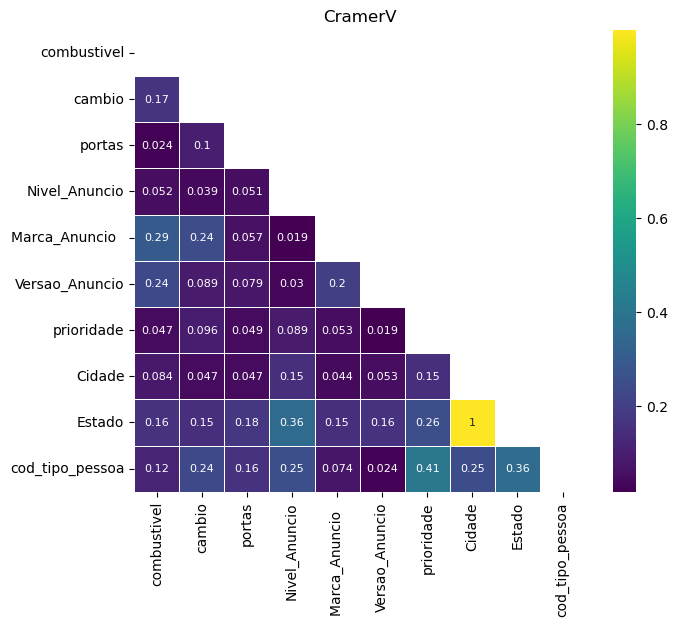

In [94]:
# Plotando a correlação
fig, ax = plt.subplots()

ax.figure.set_size_inches(16, 6)

plt.subplot(1,2,1)

TrueFalse = np.triu(np.ones_like(data_cramerv, dtype=bool))
sns.heatmap(data_cramerv, mask=TrueFalse, linewidths=.5, annot=True, annot_kws={"fontsize":8}, cmap='viridis')
plt.title("CramerV")

plt.show()

### 6.3.3 Atributos Numéricos

Nos atributos numéricos, usamos a correlação de Pearson num mapa de calor. Nesse mapa, observamos uma correlação mais baixa entre elas, com uma minoria alta variando entre **0.23** e **0.37**.

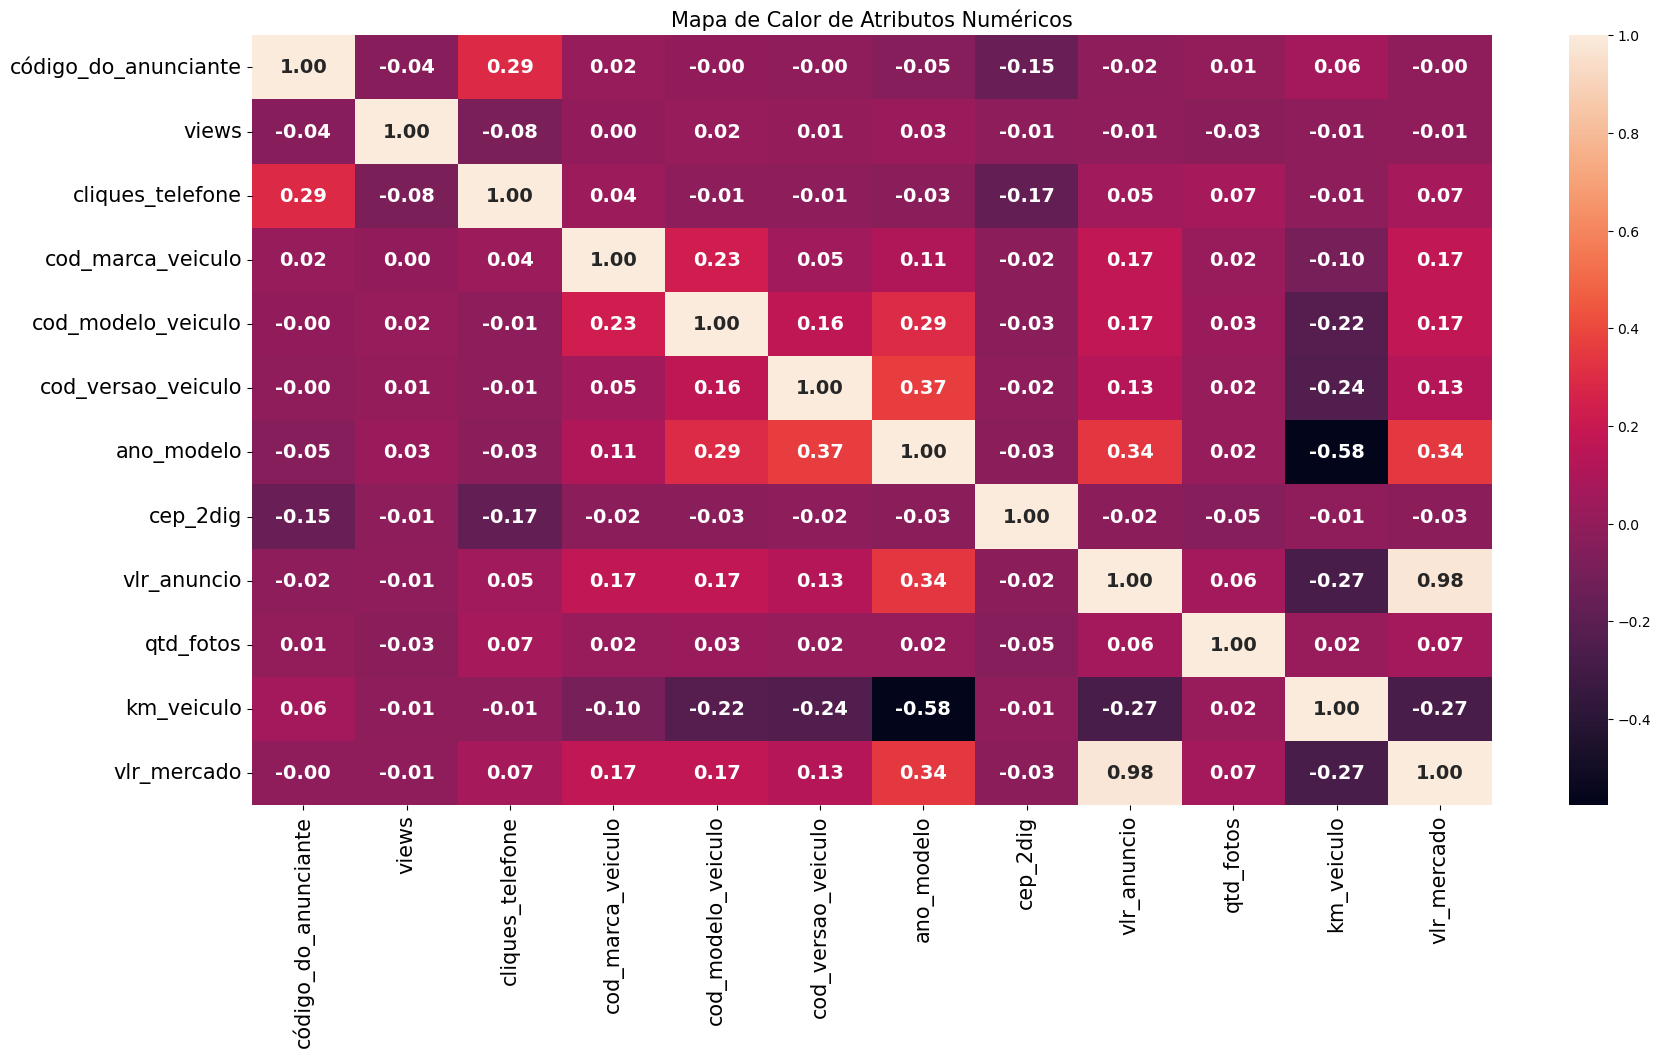

In [95]:
# Correlação entre dados int e float
NIF = numerical.select_dtypes(['int64','int32', 'float64'])
atributos_num = NIF.corr( method='pearson' )
plt.figure( figsize=(20, 10) )
ax1 = sns.heatmap(data=atributos_num, annot=True, fmt='.2f', annot_kws={'fontsize':14, 'fontweight':'bold'})
ax1.set_xticklabels(atributos_num, fontsize=15)
ax1.set_yticklabels(atributos_num, fontsize=15)
data_load(ax1, 'Mapa de Calor de Atributos Numéricos', '', '')

### 6.3.4 Atributos Binários

Nos atributos binários, usamos a correlação de Pearson também e obtivemos bons altas correlações entre elas, principalmente entre as variáveis **flg_todas_revisoes_concessionaria**, **flg_todas_revisoes_agenda_veiculo** e **flg_garantia_fabrica**.

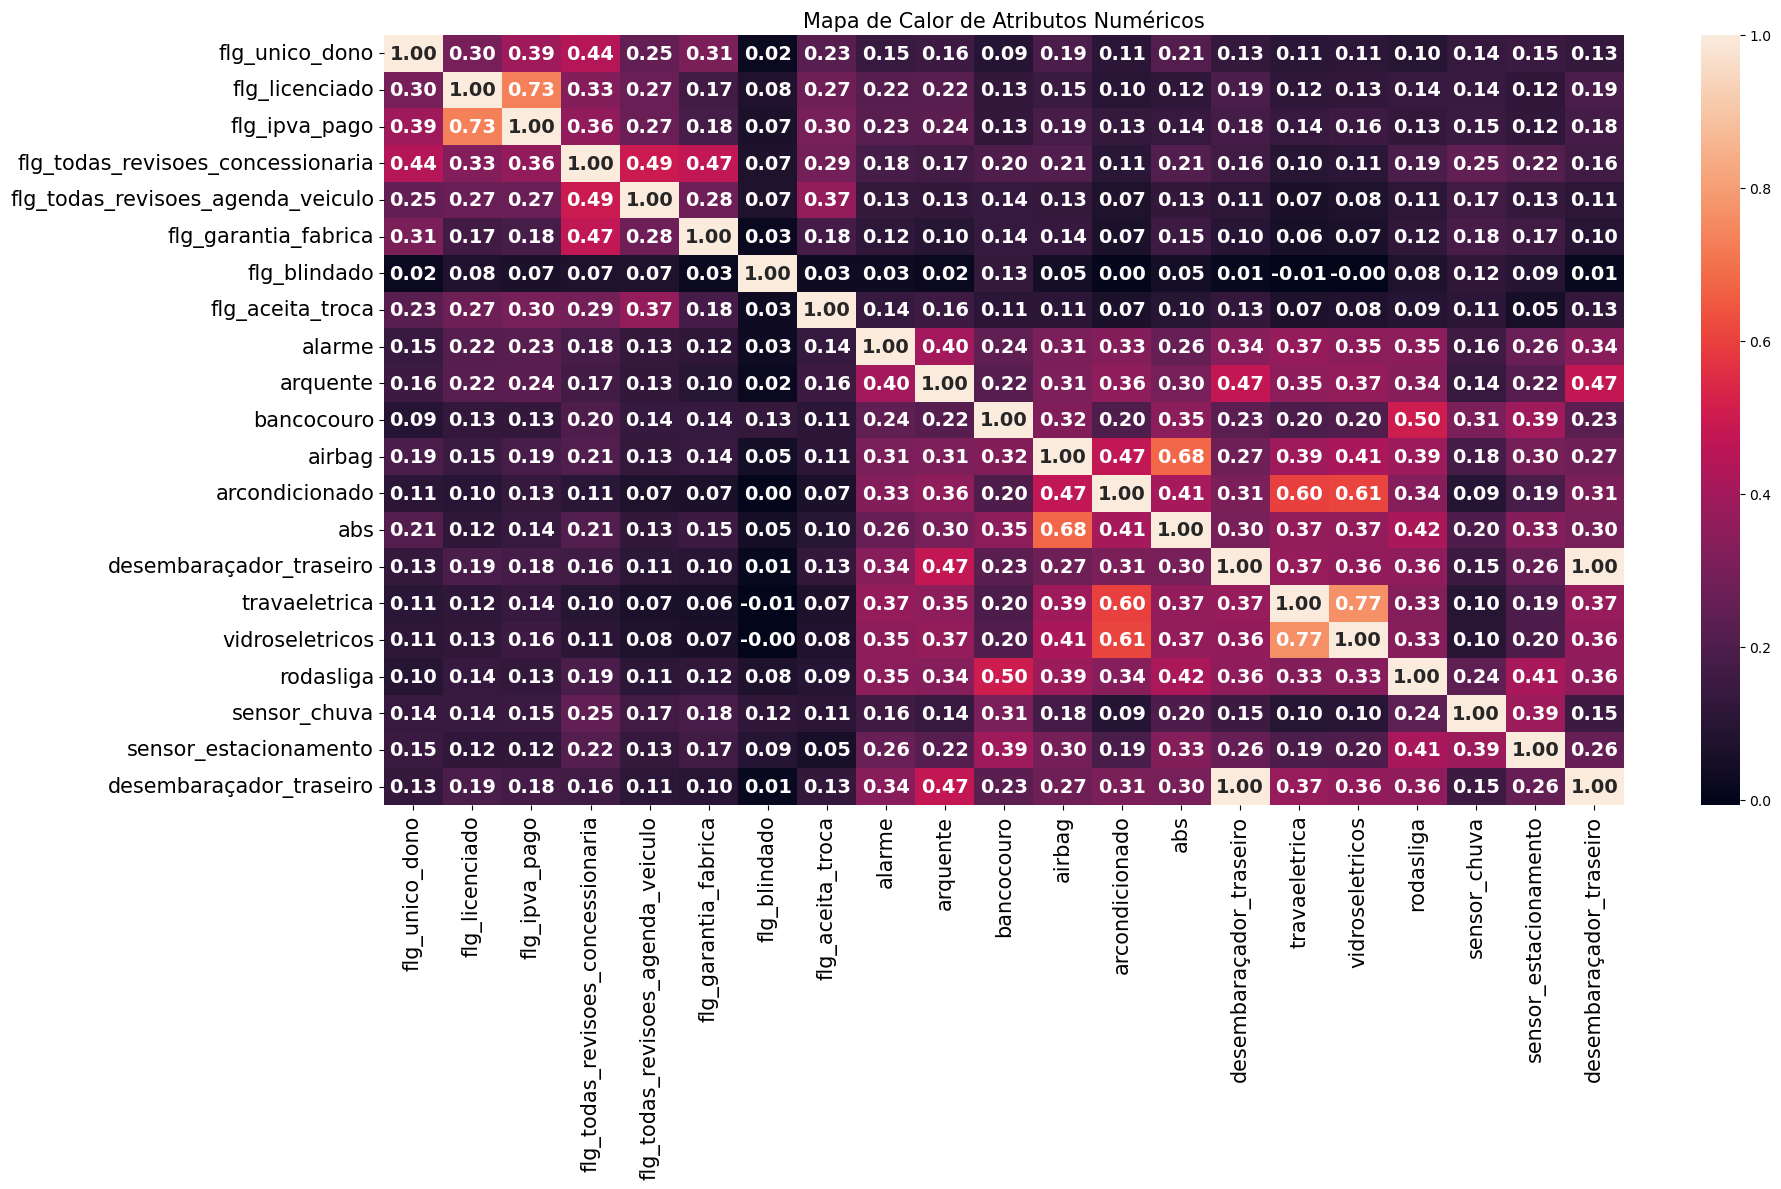

In [96]:
atributos_bin = binary.corr( method='pearson' )
plt.figure( figsize=(20, 10) )
ax1 = sns.heatmap(data=atributos_bin, annot=True, fmt='.2f', annot_kws={'fontsize':14, 'fontweight':'bold'})
ax1.set_xticklabels(atributos_bin, fontsize=15)
ax1.set_yticklabels(atributos_bin, fontsize=15)
data_load(ax1, 'Mapa de Calor de Atributos Numéricos', '', '')


# 7.0 Data preprocessing

## 7.1 treino e teste

Divisão de treino e teste é feito antes do pré-processamento e desbalanceamento dos dados para evitar overfiting.

In [127]:
X = data1.drop(['leads_class'], axis=1)
y = data1[['leads_class']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

## 7.2 Normalização

In [128]:
train_scale = X_train[['código_do_anunciante', 'views', 'cliques_telefone',
       'cod_marca_veiculo', 'cod_modelo_veiculo', 'cod_versao_veiculo',
       'ano_modelo', 'cep_2dig', 'vlr_anuncio', 'qtd_fotos', 'km_veiculo',
       'vlr_mercado']]
test_scale = X_test[['código_do_anunciante', 'views', 'cliques_telefone',
       'cod_marca_veiculo', 'cod_modelo_veiculo', 'cod_versao_veiculo',
       'ano_modelo', 'cep_2dig', 'vlr_anuncio', 'qtd_fotos', 'km_veiculo',
       'vlr_mercado']]

In [129]:
# Instanciando a normalização 
escala_mm = MinMaxScaler()
escala_mm.fit(train_scale)

# Reescalando os dados numerical
train_numerical = escala_mm.transform(train_scale.values)
test_numerical = escala_mm.transform(test_scale.values)

train_numerical_scaled = pd.DataFrame(train_numerical, columns=train_scale.columns)
test_numerical_scaled = pd.DataFrame(test_numerical, columns=test_scale.columns)

In [130]:
pickle.dump(escala_mm, open('Models/numerical_scaler.pkl', 'wb'))

## 7.3 Transformação


In [131]:
# Selecionando as colunas binárias
train_binary = X_train[['flg_unico_dono', 'flg_licenciado', 'flg_ipva_pago',
       'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_garantia_fabrica',
       'flg_blindado', 'flg_aceita_troca']]
test_binary = X_test[['flg_unico_dono', 'flg_licenciado', 'flg_ipva_pago',
       'flg_todas_revisoes_concessionaria',
       'flg_todas_revisoes_agenda_veiculo', 'flg_garantia_fabrica',
       'flg_blindado', 'flg_aceita_troca']]

train_binary = train_binary.reset_index(drop=True)
test_binary = test_binary.reset_index(drop=True)

In [132]:
# Selecionando as colunas de valores categóricos
train_categorical = X_train[['alarme', 'arquente', 'bancocouro',
       'airbag', 'arcondicionado', 'abs', 'desembaraçador_traseiro',
       'travaeletrica', 'vidroseletricos', 'rodasliga', 'sensor_chuva',
       'sensor_estacionamento', 'desembaraçador_traseiro']]
test_categorical = X_test[['alarme', 'arquente', 'bancocouro',
       'airbag', 'arcondicionado', 'abs', 'desembaraçador_traseiro',
       'travaeletrica', 'vidroseletricos', 'rodasliga', 'sensor_chuva',
       'sensor_estacionamento', 'desembaraçador_traseiro']]

train_categorical.reset_index(drop=True, inplace=True)
test_categorical.reset_index(drop=True, inplace=True)

train_cat_code = pd.get_dummies(train_categorical, drop_first=True)
test_cat_code = pd.get_dummies(test_categorical, drop_first=True)

## 7.4 Frequências

In [133]:
# Selecionando as colunas categorical
train_cat_ = X_train[['cod_tipo_pessoa', 'combustivel', 'cambio', 'portas', 'Nivel_Anuncio',
       'Marca_Anuncio', 'Versao_Anuncio', 'prioridade', 'Cidade', 'Estado']]
test_cat_ = X_test[['cod_tipo_pessoa', 'combustivel', 'cambio', 'portas', 'Nivel_Anuncio',
       'Marca_Anuncio', 'Versao_Anuncio', 'prioridade', 'Cidade', 'Estado']]

In [134]:
# Enumerando em ordem os índices
train_cat_.reset_index(drop=True, inplace=True)
test_cat_.reset_index(drop=True, inplace=True)

In [135]:
train_cat_codificado = frequencias_codificadas(train_cat_)
test_cat_codificado = frequencias_codificadas(test_cat_)

### 7.5 Transformação das Variáveis


In [136]:
# Concatenando os dados de transformação de treino
X_train_ = pd.concat([train_numerical_scaled, train_binary,train_cat_codificado], axis=1)
X_test_ = pd.concat([test_numerical_scaled, test_binary,test_cat_codificado], axis=1)

# 8 Seleção de Recursos

Nesse módulo, fizemos a seleção dos recursos pelo método **Extra Tree Classifier** que cria muitas árvores de decisão de maneira aleatória, para então através da combinação dos resultados de cada árvore encontrar a resposta final. No final, escolhemos os 14 melhores recursos para aplicar no modelo de Machine Learning.

## 8.1 Extra Tree Classifier

In [137]:
# define training test data for Boruta
X = X_train_.copy()
y = y_train.copy()
y=y.astype('float')
X=X.astype('float')

In [138]:
# Instanciando o ExtraTreesClassifier
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=43, n_jobs=-1)

# Treinando pelo ExtraTreesClassifier
forest.fit(X, y)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=43)

Ranking de Ferramenta: 
                          Ferramenta  Importância
0                              views     0.072124
0                   cliques_telefone     0.069909
0                         km_veiculo     0.067809
0                        vlr_mercado     0.065425
0               código_do_anunciante     0.064941
0                        vlr_anuncio     0.064383
0                 cod_versao_veiculo     0.060791
0                 cod_modelo_veiculo     0.057376
0                         ano_modelo     0.056878
0                           cep_2dig     0.055100
0                  cod_marca_veiculo     0.052696
0                          qtd_fotos     0.050030
0                             Cidade     0.049674
0                     Versao_Anuncio     0.028599
0                             Estado     0.027509
0                             cambio     0.021155
0                      Nivel_Anuncio     0.019331
0                        combustivel     0.015143
0                     flg_

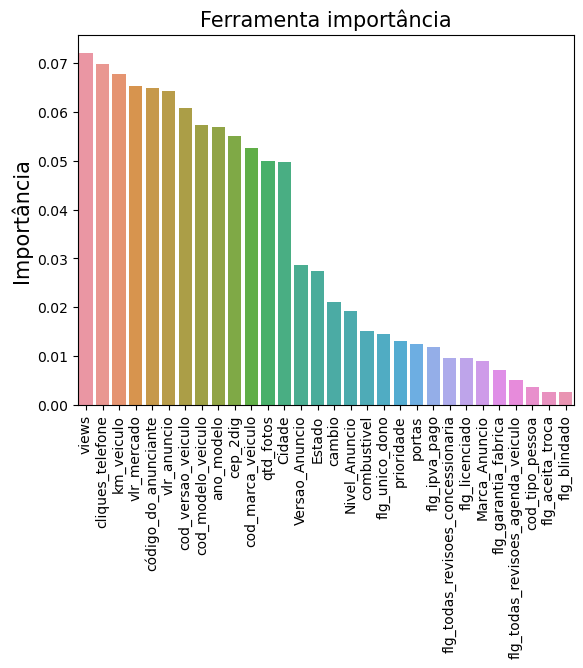

In [139]:
# a importância de cada feature de acordo com o modelo(média)
important_features = forest.feature_importances_

# Ranking das features
print('Ranking de Ferramenta: ')
ranking = pd.DataFrame()
for a, b in zip(X, forest.feature_importances_):
    lista = pd.DataFrame({'Ferramenta': a, 'Importância': b}, index=[0])
    ranking = pd.concat([ranking,lista], axis=0)
    
print(ranking.sort_values('Importância', ascending=False))

# plotando os rankings das features
ax1 = sns.barplot(data=ranking.sort_values('Importância', ascending=False), x='Ferramenta', y='Importância' )
data_load(ax1, 'Ferramenta importância', '', 'Importância')
plt.xticks( rotation=90 );

In [140]:
# desvio padrão de cada importância de features
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# ordem de maiores índices por importância de features do maior para o menor
indices = np.argsort(important_features)[::-1]

In [141]:
selecionar_colunas = list(ranking.sort_values('Importância', ascending=False)['Ferramenta'][:14])

X_ = X[selecionar_colunas]

# 9 Machine Learning



#### 0 = Não possui Leads
#### 1 = Possui Leads

## 9.1 Balanceando os dados

Devido à quantidade de leads(se tem leads ou não) não estar bem balanceada, fizemos o balanceamento dos dados para obter uma acurácia maior pelo método do **SMOTETomek**.

In [142]:
X_train_ = X_train_.astype('float')
X_test_ = X_test_.astype('float')
y_train = y_train.astype('float')
y_test = y_test.astype('float')

# definindo o resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# Transformando o dataset treino
X_train_balanceado, y_train_balanceado = resampler.fit_resample(X_train_[X_.columns.tolist()], y_train)
# Transformando o dataset teste
X_test_balanceado, y_test_balanceado = resampler.fit_resample(X_test_[X_.columns.tolist()], y_test)


# Contando o número de classe após o oversampling
counter_train = Counter(y_train_balanceado)
counter_test = Counter(y_test_balanceado)
print('After balancing:', counter_train)
print('After balancing:', counter_test)

After balancing: Counter({'leads_class': 1})
After balancing: Counter({'leads_class': 1})


## 9.2 Treinando os modelos e calculando as métricas

Nesse módulo, aplicamos os modelos de Machine Learning e os algoritmos que melhor atenderam às necessidades dos pacientes de forma rápida e com uma precisão melhor foram o **LGBMClassifier** , **CatBoostClassifier** e **XGBClassifier**, pois possuem boa acurácia do F1-Score que é o que procuramos. Os três algoritmos possuem resultados bem parecidos, mas escolhemos o **LGBMClassifier** por ter uma velocidade maior no processamento. 

In [160]:
THRESHOLD = 0.45

classifiers = [LogisticRegression(max_iter=220, random_state=42),
               RandomForestClassifier(random_state=42),
               xgb.XGBClassifier(random_state=42),
               BalancedRandomForestClassifier(random_state=42),
               CatBoostClassifier(random_state=42, verbose=False),
               KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1),
               SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1), 
               LGBMClassifier(random_state=42, n_jobs=-1,verbose=-1), 
               GaussianNB()]

performance_dados1 = UG.performance_modelo(X_train_balanceado, X_test_balanceado, 
                                                y_train_balanceado.values.ravel(), y_test_balanceado.values.ravel(), 
                                                THRESHOLD, classifiers)

Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
Training BalancedRandomForestClassifier...
Training CatBoostClassifier...
Training KNeighborsClassifier...
Training SGDClassifier...
Training LGBMClassifier...
Training GaussianNB...


In [161]:
performance_dados1.style.highlight_max(color='darkorange')

,model,precision,recall,f1-Score,ROC AUC,accuracy,cohen kappa
0,LogisticRegression,0.526103,0.716958,0.606879,0.595961,0.535572,0.071144
2,RandomForestClassifier,0.694848,0.725851,0.710011,0.759499,0.703542,0.407084
4,XGBClassifier,0.785306,0.737504,0.760655,0.867079,0.767939,0.535879
6,BalancedRandomForestClassifier,0.691822,0.722478,0.706818,0.755217,0.700322,0.400644
8,CatBoostClassifier,0.786563,0.741337,0.763280,0.865230,0.770086,0.540172
10,KNeighborsClassifier,0.519508,0.596136,0.555191,0.536252,0.522386,0.044772
12,SGDClassifier,0.499653,0.994634,0.665163,0.587767,0.499310,-0.001380
14,LGBMClassifier,0.784356,0.733364,0.758003,0.845333,0.765869,0.531739
16,GaussianNB,0.636888,0.338853,0.442354,0.603835,0.572830,0.145661


## 9.2 ROC AUC


Feito o gráfico da curva ROC, observamos como o modelo KNeighborsClassifier é bom comparado à reta sem habilidade.

In [165]:
# Instanciando LGBMClassifier
LGBMClassifier_ = LGBMClassifier(n_neighbors=5,  weights='distance',n_jobs=-1, verbose=-1)

# Treinando LGBMClassifier
LGBMClassifier_.fit(X_train_balanceado, np.ravel(y_train_balanceado))

# Calculando as probabilidades de predição
y_pred_rf_prob = LGBMClassifier_.predict_proba(X_test_balanceado)[:,1]

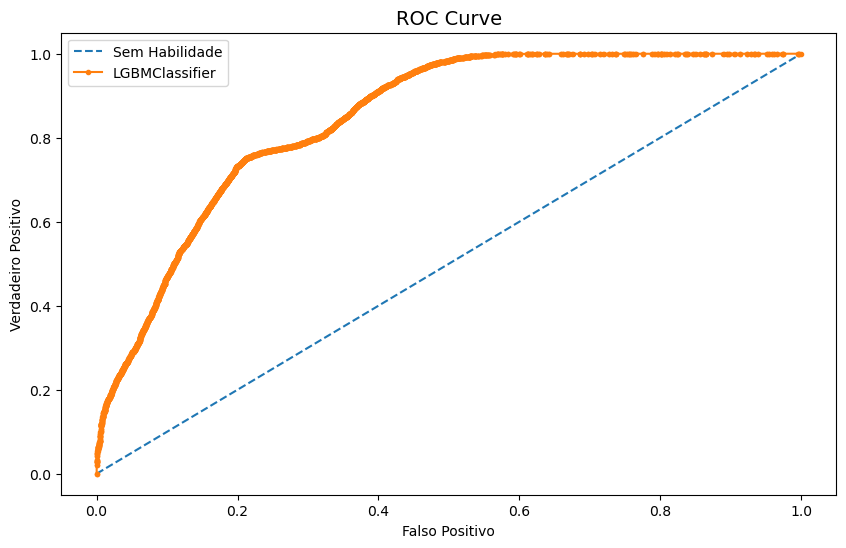

In [166]:
# Plotando a curva ROC AUC
fig, ax = plt.subplots()

ax.figure.set_size_inches(10, 6)

ns_probs = [0 for _ in range(len(y_test_balanceado))]

ns_fpr, ns_tpr, _ = roc_curve(y_test_balanceado, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test_balanceado, y_pred_rf_prob)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sem Habilidade')
plt.plot(rf_fpr, rf_tpr, marker='.', label='LGBMClassifier')

plt.title("ROC Curve", fontsize=14)
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')

plt.legend()

plt.show()

In [167]:
pickle.dump(LGBMClassifier_, open('Models/LGBMClassifier_.pkl', 'wb'))

# 9.3 Matriz de Confusão


Possui também a menor porcentagem de falsos positivos(**precision**), no qual afirmamos com mais precisão que os dados aplicados possuem leads. Por outro lado, observamos que possui alta taxa de falsos negativos(**recall**), mas é melhor errarmos afirmando que não tem leads, quando na verdade tem (não temos nada a perder) do que afirmarmos que possui leads sem ter(podemos contar algum lucro sem ter).

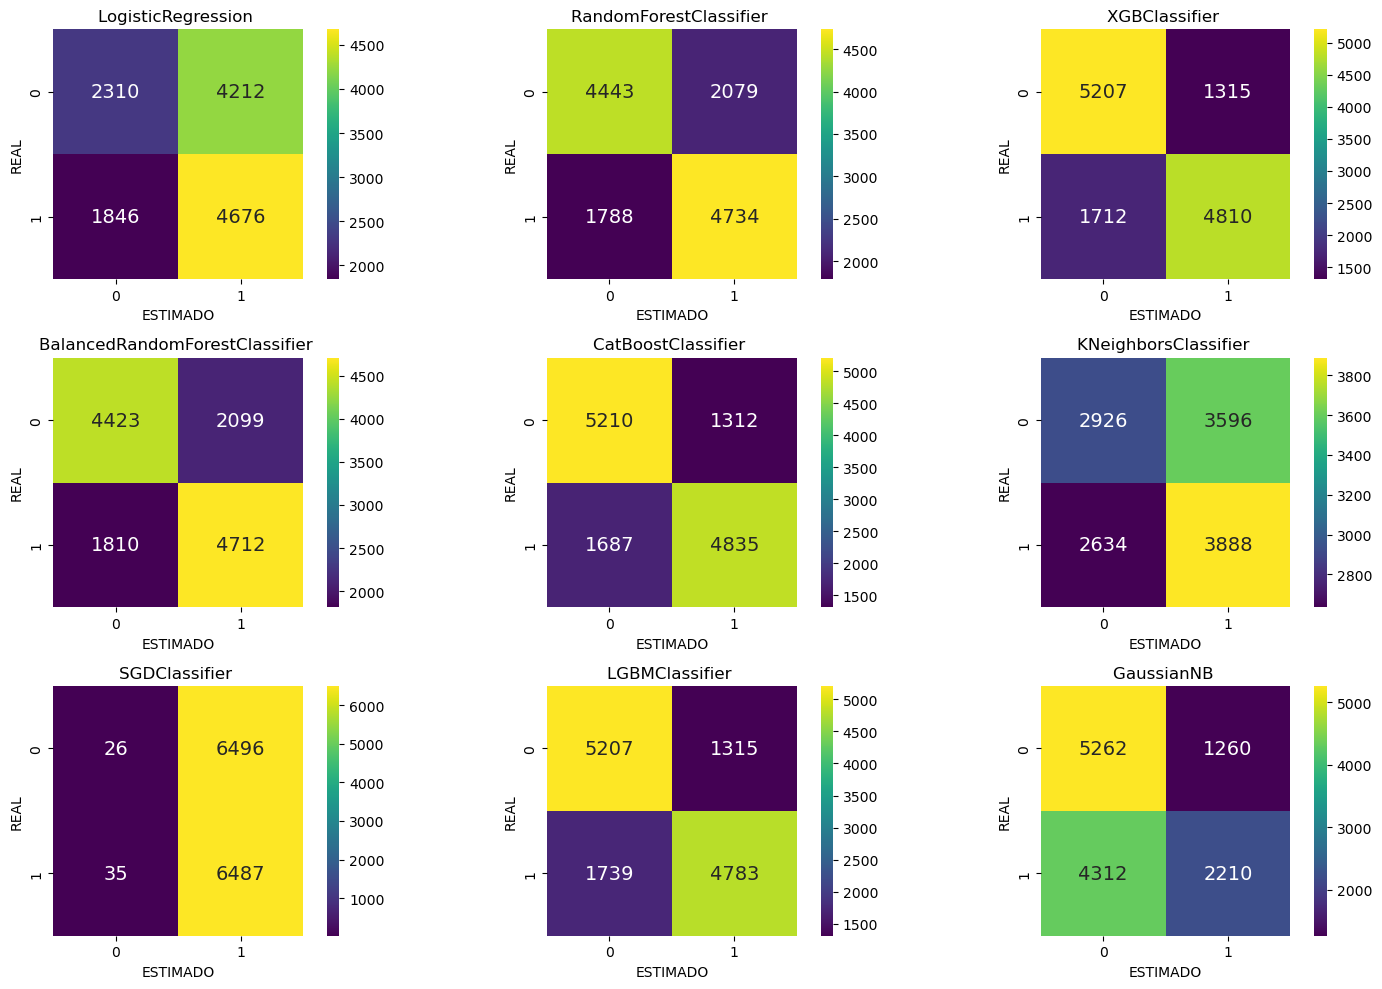

In [168]:
# Selecionar as dimensões das subplots
n_rows = 3
n_cols = 3
threshold = 0.45
model = classifiers
qualifier=""

# Plotando matriz de confusão
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

for clf, ax, n in zip(classifiers, ax.flatten(), list(range(n_rows*n_cols))):
    clf_probs = clf.predict_proba(X_test_balanceado)

    probs = pd.DataFrame(clf_probs[:, 1], columns=['prob_positivo'])

    y_pred = probs['prob_positivo'].apply(
        lambda x: 1 if x > threshold else 0)

    plt.subplot(n_rows, n_cols, n+1)
    cm = confusion_matrix(y_test_balanceado, y_pred)

    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='viridis',
                    square=True, annot_kws={"size": 14})

    plt.xlabel("ESTIMADO")
    plt.ylabel("REAL")
    ax.title.set_text(type(clf).__name__ + ' ' + str(qualifier))

plt.tight_layout()

plt.show()             

# 9.4 Validação-Cruzada

Usamos a Validação-Cruzada(Cross-Validation) para tentar deixar nosso modelo mais preciso.

In [169]:
# Concatenando dados de teste e treino pelo método Boruta
X_all = pd.concat([X_train_balanceado, X_test_balanceado], axis=0)
y_all = pd.concat([y_train_balanceado, y_test_balanceado], axis=0)

In [170]:
LGBMClassifier_ = pickle.load(open('Models/LGBMClassifier_.pkl', 'rb'))

In [171]:
# Instanciando o StratifiedKFold para Cross-validation
cv = StratifiedKFold(n_splits=10)

In [172]:
# Calculando acurácia de precision
cv_scores = cross_val_score(LGBMClassifier_, X_all, y_all.values.ravel(), cv=cv, scoring='precision', n_jobs=1)
print("Average precision : %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))
print()

# Calculando acurácia de recall
cv_scores1 = cross_val_score(LGBMClassifier_, X_all, y_all.values.ravel(), cv=cv, scoring='recall', n_jobs=1)
print("Average recall : %0.4f (+/- %0.4f)" % (cv_scores1.mean(), cv_scores1.std() * 2))
print()

# Calculando acurácia de f1-score
cv_score2 = cross_val_score(LGBMClassifier_, X_all, y_all.values.ravel(), cv=cv, scoring='f1', n_jobs=1)
print("Average f1-score : %0.4f (+/- %0.4f)" % (cv_score2.mean(), cv_score2.std() * 2))
print()

# Calculando acurácia de roc_auc
cv_score3 = cross_val_score(LGBMClassifier_, X_all, y_all.values.ravel(), cv=cv, scoring='roc_auc', n_jobs=1)
print("Average roc_auc : %0.4f (+/- %0.4f)" % (cv_score3.mean(), cv_score3.std() * 2))
print()

Average precision : 0.8366 (+/- 0.3965)

Average recall : 0.9972 (+/- 0.0112)

Average f1-score : 0.8955 (+/- 0.2607)

Average roc_auc : 0.8905 (+/- 0.3083)



# 10 Hiperparâmetros

Através dos hiperparâmetros vamos encontrar o desvio padrão de cada acurácia e aplicar no modelo.

In [173]:
LGBMClassifier_ = pickle.load(open('Models/LGBMClassifier_.pkl', 'rb'))

In [174]:
# Configurar com hiperparâmetros especificados
space = {'n_neighbors':list(range(5,16)),
 'p':[1,2]}


# Preparar para treinar o RandomizedSearchCV
LGB_ = RandomizedSearchCV(estimator=LGBMClassifier_, param_distributions=space,
                                scoring='f1', n_iter=100, cv=5, verbose=1,
                                random_state=42, n_jobs=-1)

In [175]:
# Treinar os dados pelo RandomizedSearchCV
LGB_.fit(X_train_balanceado.values,y_train_balanceado.values.ravel())

Fitting 5 folds for each of 22 candidates, totalling 110 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(n_jobs=-1, n_neighbors=5,
                                            verbose=-1, weights='distance'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'n_neighbors': [5, 6, 7, 8, 9, 10, 11,
                                                        12, 13, 14, 15],
                                        'p': [1, 2]},
                   random_state=42, scoring='f1', verbose=1)

In [176]:
# Calcular o melhor estimator para Modelo Final
LGB_.best_estimator_

LGBMClassifier(n_jobs=-1, n_neighbors=5, p=1, verbose=-1, weights='distance')

In [177]:
pickle.dump(LGB_.best_estimator_, open('Models/LGB_.best_estimator_.pkl', 'wb'))

# 10.1 Modelo Final


Por fim, vamos aplicar o modelo final de acordo com os dados do hiperparâmetro com o objetivo de obter o melhor resultado junto à melhor e pior hipótese(desvio padrão).

In [178]:
LGB_final_model = pickle.load(open('Models/LGB_.best_estimator_.pkl', 'rb'))

In [179]:
# Calculando acurácia de precision
cv_scores = cross_val_score(LGB_.best_estimator_, X_all,  y_all.values.ravel(), cv=cv, scoring='precision', n_jobs=1)
print("Average precision : %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))
print()

# Calculando acurácia de recall
cv_scores1 = cross_val_score(LGB_.best_estimator_, X_all,  y_all.values.ravel(), cv=cv, scoring='recall', n_jobs=1)
print("Average recall : %0.4f (+/- %0.4f)" % (cv_scores1.mean(), cv_scores1.std() * 2))
print()

# Calculando acurácia de f1-score
cv_score2 = cross_val_score(LGB_.best_estimator_, X_all,  y_all.values.ravel(), cv=cv, scoring='f1', n_jobs=1)
print("Average f1-score : %0.4f (+/- %0.4f)" % (cv_score2.mean(), cv_score2.std() * 2))
print()

# Calculando acurácia de roc_auc
cv_score3 = cross_val_score(LGB_.best_estimator_, X_all,  y_all.values.ravel(), cv=cv, scoring='roc_auc', n_jobs=1)
print("Average roc_auc : %0.4f (+/- %0.4f)" % (cv_score3.mean(), cv_score3.std() * 2))
print()

Average precision : 0.8366 (+/- 0.3965)

Average recall : 0.9972 (+/- 0.0112)

Average f1-score : 0.8955 (+/- 0.2607)

Average roc_auc : 0.8905 (+/- 0.3083)



# 11 Performance de Negócio

A principal ferramenta do Autopago, solução de tecnologia da **Webmotors**, está na segurança, pois acaba com os riscos das transações entre pessoas físicas, protegendo comprador e vendedor, uma vez que o dinheiro do comprador permanece em uma conta segura da Webmotors e só é depositado ao vendedor 24 horas após o negócio seer concretizado.

**A Webmotors cobra 1,5% do valor do veículo. Este custo pode ficar a cargo do comprador, ou do vendedor, ou mesmo os dois podem dividir o montante, com cada um custeando 0,75%.**

 



O modelo **KNeighborsClassifier** possui a menor porcentagem de falsos positivos(precision), ou seja, afirmamos com mais precisão que os dados aplicados possuem leads corretamente, erramos muito menos. Por outro lado, observamos que possui alta taxa de falsos negativos(recall), mas é melhor errarmos afirmando que não tem leads quando na verdade tem (se errarmos, erramos positivamente), do que afirmarmos que possui leads sem ter, pois corremos o risco de contar algum lucro sem ter e não tomaremos nenhuma atitude para melhorar.

| Predição                | Real               | Resultado                  | 
:------------------------ | :------------------| :------------------------- | 
| Obteve lead(s)          | Não obteve lead(s) | Sem monetização e prejuízo | 
| Não obteve lead(s)      | Obteve lead(s)     | Monetização e sem prejuízo | 

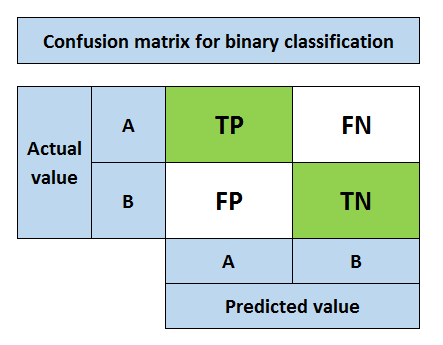

In [259]:
# Imagem do mapa de hipóteses
Image( 'Images/confusion_matrix.png' )